# Non linear feature extraction of the stratosphere

## Set-up: 

### Imports:

In [1]:
from scipy.spatial import distance_matrix
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import sleep
import warnings
from sklearn.neighbors import NearestNeighbors
import scipy.sparse.linalg as linalg
import scipy.signal as signal
import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime
import os
import math 
warnings.filterwarnings('ignore')

from functions_takens import *

%load_ext jupyternotify
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

### Constants:

In [2]:
# Percentage of nearest neighbours:
PERC_NEIGH = 10
print(f'Percentage of nearest neighbours: {PERC_NEIGH/100}')

# Number of eigenmaps to compute:
NUM_EIGENVALUES = 21
print(f'Number of eigenmaps: {NUM_EIGENVALUES}')

# Data set to consider: ('raw/anomalies')
DATA = 'raw'
print(f'Data set considered: {DATA}')

# Path to input data:
INPUT_DATA = '../../../data/vandermeer/input_data/'
print(f'Path to input data: {INPUT_DATA}')

# Wether to do NLSA or Laplacian Eigenmaps. Takens True for NLSA
USE_TAKENS = True
print(f'Using takens embedding: {USE_TAKENS}')

# Time-step in Takens embedding:
TAU = 4 * 30 * 2
print(f'tau = {TAU/(4*30)} months')

BEGIN_YEAR = 1979
END_YEAR = 2019


Percentage of nearest neighbours: 0.1
Number of eigenmaps: 21
Data set considered: raw
Path to input data: ../../../data/vandermeer/input_data/
Using takens embedding: True
tau = 2.0 months


Constants for plots:

In [3]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Paths:

Global path to save data: 

In [4]:
if DATA == 'raw':
    PATH = '../../../data/vandermeer/pickles/raw/'
elif DATA == 'anomalies': 
    PATH = '../../../data/vandermeer/pickles/anomalies/'
if not os.path.exists(PATH):
        os.makedirs(PATH)
print(f'Global path: {PATH}')

Global path: ../../../data/vandermeer/pickles/raw/


Path to save data according to the percentage of neighbours used: 

In [5]:
PATH1 = PATH + str(PERC_NEIGH)+'perc/'
if not os.path.exists(PATH1):
        os.makedirs(PATH1)
print(f'Precise path: {PATH1}')

Precise path: ../../../data/vandermeer/pickles/raw/10perc/


Path to save data of simple kernel (binary kernel): 

In [6]:
# path to simple_kernel:
PATH_SIMPLE = PATH1 + 'simple_kernel/'
if not os.path.exists(PATH_SIMPLE):
        os.makedirs(PATH_SIMPLE)
print(f'Path to simple kernel: {PATH_SIMPLE}')

PATH_SIMPLE_TAKENS = PATH1 + 'simple_kernel/takens/'
if not os.path.exists(PATH_SIMPLE_TAKENS):
        os.makedirs(PATH_SIMPLE_TAKENS)
print(f'Path to simple kernel for NLSA: {PATH_SIMPLE_TAKENS}')

Path to simple kernel: ../../../data/vandermeer/pickles/raw/10perc/simple_kernel/
Path to simple kernel for NLSA: ../../../data/vandermeer/pickles/raw/10perc/simple_kernel/takens/


Path to save results of NLSA with correct neighbour percentage:

In [7]:
# path to NLSA results:
PATH_TAKENS = PATH + str(PERC_NEIGH)+'perc/takens/'
if not os.path.exists(PATH_TAKENS):
        os.makedirs(PATH_TAKENS)
print(f'Path to NLSA results: {PATH_TAKENS}')

Path to NLSA results: ../../../data/vandermeer/pickles/raw/10perc/takens/


## PCA: 

### Build takens matrix:

In [8]:
if DATA == 'raw':
    df = pd.read_csv(INPUT_DATA + 'raw_data_coefficients.csv', sep=',')
elif DATA == 'anomalies': 
    df = pd.read_csv(INPUT_DATA + 'anomalies_coefficients.csv', sep=',')
print(f'Input data shape: {df.shape}')

Input data shape: (33960, 1003)


$Y[t,1:D] = X[t,1:D]$


$Y[t,(D+1):(2D)] = X[t+1, 1:D] $ ...

In [9]:
BEGIN_YEAR, END_YEAR

(1979, 2019)

In [10]:
time = df['Date']
time = pd.to_datetime(time)
df_ = df.drop(['Unnamed: 0', 'Date'], axis=1)
df_time = pd.concat([time, df_], axis=1)
df_time = df_time.set_index('Date')

years = range(BEGIN_YEAR, END_YEAR)
years = [str(y) for y in years]

counts = {}
sum_ = 0
for y in years:
    sum_ += len(df_time[y])
    counts[y] = len(df_time[y])

In [11]:
cs = [counts[i] for i in years]
last_year_pos = [np.sum(cs[:i+1]) for i in range(len(cs))]

entire_winters = END_YEAR-BEGIN_YEAR-1
print(f'Number of entire winters: {entire_winters}')

Number of entire winters: 39


In [12]:
last_pos_winters = give_last_post_winters(last_year_pos, years, df_time)
first_pos_winters = give_first_post_winters(last_year_pos, years, df_time)
assert(len(last_pos_winters)==len(first_pos_winters))

np.save(PATH1+'last_pos_winters.npy', last_pos_winters)
np.save(PATH1+'first_pos_winters.npy', first_pos_winters)

In [13]:
indices_of_points = []
for i in range(len(first_pos_winters)):
    indices_of_points.append(
        range(first_pos_winters[i] , last_pos_winters[i] -TAU+1, 1))
for i in indices_of_points:
    assert (i[-1] - i[0] > 600)

#indices_of_points

In [14]:
%%time
# Safety check to see everything is working all right:
# total number of points:
le = np.sum([len(i) for i in indices_of_points])
# time series corresponding to those points:
time_nlsa = time[indices_of_points[0]]
for i in range(1, len(last_pos_winters)):
    time_nlsa = pd.concat([time_nlsa, time[indices_of_points[i]]], axis = 0)
assert(le==len(time_nlsa))

CPU times: user 28.5 ms, sys: 79 µs, total: 28.5 ms
Wall time: 27.8 ms


In [15]:
indices_m = []
for j in range(len(indices_of_points)):
    for i in range(len(indices_of_points[j])):
        indices_m.append(indices_of_points[j][i])
assert(len(indices_m)==le)
print(f'First and last indice: {indices_m[0]}, {indices_m[-1]}')

First and last indice: 481, 33352


In [16]:
%%time
#Number of entire winters:
num_years = END_YEAR-BEGIN_YEAR-1
print(f'Number of years: {num_years}')

X = df.drop(['Unnamed: 0', 'Date'], axis = 1).values
# shape T - m*Tau, D
D = 150
m,n  = le, TAU*D
takens_Y = np.zeros((m,n))
print(f'New distance matrix shape: {takens_Y.shape}')

Number of years: 39
New distance matrix shape: (23752, 36000)
CPU times: user 57.3 ms, sys: 44.3 ms, total: 102 ms
Wall time: 100 ms


In [17]:
%%time
m, n = takens_Y.shape[0], takens_Y.shape[1]
print(f'New distance matrix being constructed of shape {takens_Y.shape}')

for i in tqdm(range(m)):
    # construct upper triangle as matrix is symmetric:
    indice_row = indices_m[i]
    # X[t, 1:D]
    row = X[indice_row, :D]
    for t in range(1, TAU):
        # X[t+1, 1:D]
        row = np.concatenate((row, X[indice_row+t,:D]))
    takens_Y[i,:len(row)] = row
    
takens_Y_df = pd.DataFrame(takens_Y)
    
print(f'Saving takens matrix at {PATH1}')
takens_Y_df.to_pickle(PATH1 + 'takens_Y_df_{}.pkl'.format(D))

  0%|          | 0/23752 [00:00<?, ?it/s]

New distance matrix being constructed of shape (23752, 36000)


100%|██████████| 23752/23752 [02:41<00:00, 147.13it/s]


Saving takens matrix at ../../../data/vandermeer/pickles/anomalies/10perc/
CPU times: user 2min 37s, sys: 7.23 s, total: 2min 44s
Wall time: 3min 11s


In [19]:
takens_Y_df = pd.read_pickle(PATH1 + 'takens_Y_df_{}.pkl'.format(D))
print(takens_Y_df.shape)
takens_Y_df.head(4)

KeyboardInterrupt: 

In [ ]:
del takens_Y_df

### PCA on takens matrix:

In [8]:
from sklearn.decomposition import PCA
NUM_EIGENVALUES = 20

In [9]:
%%time
D = 150
takens_Y = pd.read_pickle(PATH1 + 'takens_Y_df_{}.pkl'.format(D)).values
takens_Y.shape

CPU times: user 67.9 ms, sys: 9.97 s, total: 10 s
Wall time: 1min 41s


(23752, 36000)

In [10]:
%%time
# PCA:
pca = PCA(n_components=NUM_EIGENVALUES)
pca.fit(np.array(takens_Y.T))

singular_values_pca = pca.singular_values_
explained_variance_ratio__pca = pca.explained_variance_ratio_
components_pca = pca.components_

print("Singular values: {sv} \nExplained variance: {ev}".format(
    sv=singular_values_pca, ev=explained_variance_ratio__pca))
del distance_matrix

Singular values: [0.97872817 0.10895828 0.09346619 0.06406606 0.05970918 0.0538317
 0.0497059  0.04820604 0.04700887 0.0420828  0.03957752 0.03768314
 0.03508382 0.03370333 0.03270371 0.03212262 0.03037807 0.03023104
 0.02933355 0.02916674] 
Explained variance: [9.05101899e-01 1.12174412e-02 8.25434034e-03 3.87819199e-03
 3.36864745e-03 2.73810074e-03 2.33447458e-03 2.19571630e-03
 2.08801143e-03 1.67333333e-03 1.48003006e-03 1.34173693e-03
 1.16301960e-03 1.07329475e-03 1.01057238e-03 9.74978755e-04
 8.71953895e-04 8.63534307e-04 8.13022358e-04 8.03801755e-04]
CPU times: user 5min 29s, sys: 1min 50s, total: 7min 20s
Wall time: 59.1 s


In [11]:
print(f'Shape of eigenvectors for PCA: {components_pca.shape}')

Shape of eigenvectors for PCA: (20, 23752)


In [12]:
pd.DataFrame(components_pca.T).head()

0         1         2         3         4         5         6   \
0  0.006269 -0.002357  0.004247 -0.011059 -0.001043 -0.004441 -0.003152   
1  0.006277 -0.002305  0.004206 -0.011158 -0.001144 -0.004434 -0.003149   
2  0.006285 -0.002254  0.004166 -0.011252 -0.001248 -0.004426 -0.003150   
3  0.006292 -0.002206  0.004131 -0.011343 -0.001356 -0.004417 -0.003154   
4  0.006300 -0.002158  0.004095 -0.011433 -0.001465 -0.004408 -0.003159   

         7         8         9         10        11        12        13  \
0  0.002109 -0.000164 -0.006961  0.005398  0.001790  0.001003 -0.004869   
1  0.002280 -0.000264 -0.007135  0.005512  0.001968  0.000849 -0.005174   
2  0.002452 -0.000365 -0.007285  0.005619  0.002150  0.000698 -0.005465   
3  0.002619 -0.000473 -0.007409  0.005716  0.002341  0.000547 -0.005744   
4  0.002789 -0.000583 -0.007508  0.005805  0.002539  0.000402 -0.006004   

         14        15        16        17        18        19  
0  0.002997  0.012749  0.004246 -0.004912 -0.001798 -0.005732  
1  0.002724  0.012268  0.004535 -0.004983 -0.001697 -0.006351  
2  0.002443  0.011744  0.004821 -0.005049 -0.001580 -0.006948  
3  0.002154  0.011177  0.005092 -0.005108 -0.001441 -0.007524  
4  0.001863  0.010577  0.005363 -0.005159 -0.001287 -0.008073

In [13]:
%%time
if DATA == 'anomalies':
    df = pd.read_csv(INPUT_DATA + 'anomalies_coefficients.csv', sep=',')
else:
    df = pd.read_csv(INPUT_DATA + 'raw_data_coefficients.csv', sep=',')
time = pd.to_datetime(df['Date'])
del df

CPU times: user 12.2 s, sys: 797 ms, total: 13 s
Wall time: 29.5 s


In [14]:
first_pos_winters = np.load(PATH1 + 'first_pos_winters.npy')
last_pos_winters = np.load(PATH1 + 'last_pos_winters.npy')

indices_of_points = []
for i in range(len(first_pos_winters)):
    indices_of_points.append(
        range(first_pos_winters[i] + TAU, last_pos_winters[i] + 1, 1))
for i in indices_of_points:
    assert (i[-1] - i[0] > 600)

In [15]:
time_nlsa = time[indices_of_points[0]]

for i in range(1, len(indices_of_points)):
    time_nlsa = pd.concat([time_nlsa, time[indices_of_points[i]]], axis=0)

time_nlsa = pd.to_datetime(time_nlsa)
time_nlsa.to_csv(PATH_TAKENS + 'time_nlsa.csv')

In [16]:
eigv_PCA = pd.DataFrame(components_pca.T)
eigv_PCA.index = time_nlsa

eigv_PCA.columns = range(1, NUM_EIGENVALUES+1)

In [17]:
years = range(BEGIN_YEAR, END_YEAR)
years = [str(y) for y in years]
for y in years[1:]:
    i = eigv_PCA[f'{y}-10'].index
    eigv_PCA.drop(i, inplace = True)

In [18]:
eigv_PCA.to_csv(PATH1 + 'eigv_PCA.csv')

## Plot time-series:

### Special SSW trajectories:

In [19]:
years = range(BEGIN_YEAR, END_YEAR)
years = [str(y) for y in years]

In [20]:
from dateutil.relativedelta import relativedelta

dates = [['1980-02-29-12:00:00', 'D'],
         ['1981-03-04-12:00:00', 'D'], ['1981-12-04-12:00:00', 'D'],
         ['1984-02-24-12:00:00', 'D'], ['1985-01-01-12:00:00', 'S'],
         ['1987-01-23-12:00:00', 'D'], ['1987-12-08-12:00:00', 'S'],
         ['1988-03-14-12:00:00', 'S'], ['1989-02-21-12:00:00', 'S'],
         ['1998-12-15-12:00:00', 'D'], ['1999-02-26-12:00:00', 'S'],
         ['2000-03-20-12:00:00', 'D'], ['2001-02-11-12:00:00', 'S'],
         ['2001-12-30-12:00:00', 'D'], ['2003-01-18-12:00:00', 'S'],
         ['2004-01-05-12:00:00', 'D'], ['2006-01-21-12:00:00', 'D'],
         ['2007-02-24-12:00:00', 'D'], ['2008-02-22-12:00:00', 'D'],
         ['2009-01-24-12:00:00', 'S'], ['2010-02-09-12:00:00', 'S'],
         ['2013-01-07-12:00:00', 'S']]

dates_ = []
for el in dates:
    year = str(pd.to_datetime(el[0]).year)
    two_months = [
        str(pd.to_datetime(el[0]) + relativedelta(months=2)), el[1] + '_TM'
    ]
    dates_.append(el)
    if (pd.to_datetime(el[0]) + relativedelta(months=2)).month < 4 and (
            pd.to_datetime(el[0]) + relativedelta(months=2)).month >= 1:
        dates_.append(two_months)
    if (pd.to_datetime(el[0]) + relativedelta(months=2)).month >= 10:
        dates_.append(two_months)

In [21]:
years_in_d = {}
for el in dates_:
    year = str(pd.to_datetime(el[0]).year)
    if year not in years_in_d:
        years_in_d[year] = [[el[0], el[1]]]
    else:
        l = [j for j in years_in_d[year]]
        l.append([el[0], el[1]])
        years_in_d[year] = l
years_in_d

{'1980': [['1980-02-29-12:00:00', 'D']],
 '1981': [['1981-03-04-12:00:00', 'D'], ['1981-12-04-12:00:00', 'D']],
 '1982': [['1982-02-04 12:00:00', 'D_TM']],
 '1984': [['1984-02-24-12:00:00', 'D']],
 '1985': [['1985-01-01-12:00:00', 'S'], ['1985-03-01 12:00:00', 'S_TM']],
 '1987': [['1987-01-23-12:00:00', 'D'],
  ['1987-03-23 12:00:00', 'D_TM'],
  ['1987-12-08-12:00:00', 'S']],
 '1988': [['1988-02-08 12:00:00', 'S_TM'], ['1988-03-14-12:00:00', 'S']],
 '1989': [['1989-02-21-12:00:00', 'S']],
 '1998': [['1998-12-15-12:00:00', 'D']],
 '1999': [['1999-02-15 12:00:00', 'D_TM'], ['1999-02-26-12:00:00', 'S']],
 '2000': [['2000-03-20-12:00:00', 'D']],
 '2001': [['2001-02-11-12:00:00', 'S'], ['2001-12-30-12:00:00', 'D']],
 '2002': [['2002-02-28 12:00:00', 'D_TM']],
 '2003': [['2003-01-18-12:00:00', 'S'], ['2003-03-18 12:00:00', 'S_TM']],
 '2004': [['2004-01-05-12:00:00', 'D'], ['2004-03-05 12:00:00', 'D_TM']],
 '2006': [['2006-01-21-12:00:00', 'D'], ['2006-03-21 12:00:00', 'D_TM']],
 '2007': [['2

In [22]:
# two month trajectories:
trajectories = []
for el in dates:
    year = str(pd.to_datetime(el[0]).year)
    two_months = [str(pd.to_datetime(el[0]) + relativedelta(months=2)), el[1] + '_TM']
    
    if pd.to_datetime(el[0]).month < 4:
        if (pd.to_datetime(el[0]) + relativedelta(months=2)).month < 4:
            trajectories.append([el, two_months])
        else:
            end_of_month = [f'{year}-03-31-12:00:00', el[1] + '_TM']
            trajectories.append([el, end_of_month])           
    else: 
        trajectories.append([el, two_months])
        
traj = {}
for el in trajectories:
    start = el[0]
    end = el[1]
    year = str(pd.to_datetime(start[0]).year)
    range_ = pd.date_range(str(pd.to_datetime(start[0]).year) + '-' +
                               str(pd.to_datetime(start[0]).month) + '-' +
                               str(pd.to_datetime(start[0]).day),
                               str(pd.to_datetime(end[0]).year) + '-' +
                               str(pd.to_datetime(end[0]).month) + '-' +
                               str(pd.to_datetime(end[0]).day),
                               freq='6H')
    type_ = el[0][1]
    if year not in traj:
        traj[year] = [[range_, type_]]
    else:
        l = [j for j in traj[year]]
        l.append([range_, type_])
        traj[year] = l
#traj

In [23]:
# traj -30 days + 10 days:
trajectories_30_10 = []

for el in dates:
    year = str(pd.to_datetime(el[0]).year)
    ten_days = [str(pd.to_datetime(el[0]) + relativedelta(days=10)), el[1] + '_TM']
    one_month = [str(pd.to_datetime(el[0]) - relativedelta(days=30)), el[1]]
    
    # in case we're in jan-april:
    if pd.to_datetime(el[0]).month < 4:
        if (pd.to_datetime(el[0]) + relativedelta(days=10)).month < 4:
            trajectories_30_10.append([one_month, ten_days])
        else:
            end_of_month = [f'{year}-03-31-12:00:00', el[1] + '_TM']
            trajectories_30_10.append([one_month, end_of_month])           
    
    # in case we're in oct-dec:
    else: 
        if (pd.to_datetime(el[0]) - relativedelta(days=30)).month >=12: 
            trajectories_30_10.append([one_month, ten_days])
        else:
            start_of_month = [f'{year}-12-01-12:00:00', el[1]]
            trajectories_30_10.append([start_of_month, ten_days])
traj_30_10 = {}
for el in trajectories_30_10:
    start = el[0]
    end = el[1]
    year = str(pd.to_datetime(start[0]).year)
    range_ = pd.date_range(str(pd.to_datetime(start[0]).year) + '-' +
                               str(pd.to_datetime(start[0]).month) + '-' +
                               str(pd.to_datetime(start[0]).day),
                               str(pd.to_datetime(end[0]).year) + '-' +
                               str(pd.to_datetime(end[0]).month) + '-' +
                               str(pd.to_datetime(end[0]).day),
                               freq='6H')
    type_ = el[0][1]
    if year not in traj_30_10:
        traj_30_10[year] = [[range_, type_]]
    else:
        l = [j for j in traj_30_10[year]]
        l.append([range_, type_])
        traj_30_10[year] = l
#traj_30_10

In [24]:
colors_points = {
    'D': 'orangered',
    'D_TM': 'darkred',
    'S': 'deepskyblue',
    'S_TM': 'darkblue'
}

In [25]:
def Diff(li1, li2):
    return (list(list(set(li1) - set(li2)) + list(set(li2) - set(li1))))

winters_S, winters_D, winters_ssw = [], [], []
for d in dates:
    year = pd.to_datetime(d[0]).year
    month = pd.to_datetime(d[0]).month
    type_ = d[1]
    if month < 10 and year not in winters_ssw:
        winters_ssw.append(year - 1)
        if type_ == 'S':
            winters_S.append(year - 1)
        else:
            winters_D.append(year - 1)
    if month >= 10 and year not in winters_ssw:
        winters_ssw.append(year)
        if type_ == 'S':
            winters_S.append(year)
        else:
            winters_D.append(year)
            
winters_ssw = np.array(winters_ssw)
winters_S = np.array(winters_S)
winters_D = np.array(winters_D)

winters_no_ssw = np.sort(Diff(range(1979, 2017, 1), winters_ssw))
print('Winters with SSW:')
print(winters_ssw)
print('Winters with SSW type split:')
print(winters_S)
print('Winters with SSW type displacement:')
print(winters_D)
print('Winters without SSW:')
print(winters_no_ssw)

Winters with SSW:
[1979 1980 1981 1983 1984 1986 1987 1987 1988 1998 1998 1999 2000 2001
 2002 2003 2005 2006 2007 2008 2009 2012]
Winters with SSW type split:
[1984 1987 1987 1988 1998 2000 2002 2008 2009 2012]
Winters with SSW type displacement:
[1979 1980 1981 1983 1986 1998 1999 2001 2003 2005 2006 2007]
Winters without SSW:
[1982 1985 1989 1990 1991 1992 1993 1994 1995 1996 1997 2004 2010 2011
 2013 2014 2015 2016]


### Plot eigenvalues:

In [26]:
def plot_eigenvalues(w_mean,
                     NUM_EIGENVALUES):
    fig, axs = plt.subplots(1, figsize=(10, 5))
        
    axs.scatter(x=range(0, NUM_EIGENVALUES),
                y=w_mean,
                marker='o',
                alpha=0.7,
                label='PCA')
    axs.set_ylabel('Eigenvalues')
    axs.set_xlabel('Number of eigenvalue')
    plt.locator_params(axis='x', nbins=21)
    axs.legend()

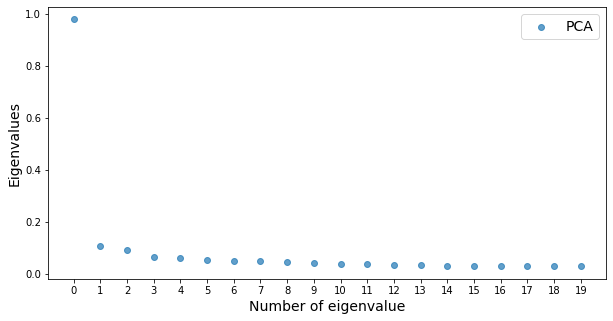

In [27]:
plot_eigenvalues(singular_values_pca, NUM_EIGENVALUES)

### Clustering:

#### Spectral clustering:

In [28]:
from sklearn.cluster import SpectralClustering

In [29]:
NUM_CLUSTERS = 2

In [30]:
%%time

#### Clustering on january-february:

jan_feb = pd.DataFrame()

y = years[1]
range_ = pd.date_range(f'{y}-01-01', f'{y}-03-01', freq = '6H')
jan_feb = eigv_PCA.loc[range_]

for y in years[2:]: 
    range_ = pd.date_range(f'{y}-01-01', f'{y}-03-01', freq = '6H')
    jan_feb = pd.concat([jan_feb, eigv_PCA.loc[range_]], axis=0)
    
# take first five eigenvectors
df_ = jan_feb[[1, 2, 3, 4, 5]]
df = np.real(df_.values)
spectral = SpectralClustering(n_clusters=NUM_CLUSTERS, random_state=0, affinity='rbf').fit(df)

jan_feb['cluster_label_spectral_kernel'] = spectral.labels_

CPU times: user 1min 39s, sys: 25.3 s, total: 2min 4s
Wall time: 15.5 s


In [31]:
%%time

#### Clustering on whole time-series:

df = np.real(eigv_PCA.values)
spectral = SpectralClustering(n_clusters=NUM_CLUSTERS, random_state=0,
                              affinity='rbf').fit(df)

eigv_PCA['cluster_label_spectral_kernel'] = spectral.labels_

CPU times: user 8min 16s, sys: 2min 15s, total: 10min 32s
Wall time: 1min 57s


#### Kernel k-means:

In [32]:
from tslearn.clustering import KernelKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

In [33]:
"""
# take first five eigenvectors
df_ = jan_feb[[1, 2, 3, 4, 5]]
df = np.real(df_.values)

seed = 0
np.random.seed(seed)
gak_km = KernelKMeans(n_clusters=NUM_CLUSTERS,
                      kernel="gak",
                      kernel_params={"sigma": "auto"},
                      n_init=1,
                      verbose=True,
                      random_state=seed)
y_pred = gak_km.fit_predict(df)
eigv_PCA['cluster_label_kernel'] = y_pred.labels_"""

'\n# take first five eigenvectors\ndf_ = jan_feb[[1, 2, 3, 4, 5]]\ndf = np.real(df_.values)\n\nseed = 0\nnp.random.seed(seed)\ngak_km = KernelKMeans(n_clusters=NUM_CLUSTERS,\n                      kernel="gak",\n                      kernel_params={"sigma": "auto"},\n                      n_init=1,\n                      verbose=True,\n                      random_state=seed)\ny_pred = gak_km.fit_predict(df)\neigv_PCA[\'cluster_label_kernel\'] = y_pred.labels_'

### Plot all eigenvectors for all years:

In [34]:
colors_lines = {
    'S': 'darkblue',
    'D': 'darkred',
    'D+S': 'darkorange',
    'N': 'green'
}

In [35]:
def plot_all_eig_clusters(eigv_time, jan_feb, colors_lines, clusters = False, traj = traj):
    fig, axs = plt.subplots(10, 1, figsize=(20, 25))
    m = 1
    for i in range(10):
        
        full_winters = pd.date_range('1980-01-01', '2017-12-31', freq = '6H')
        df = pd.DataFrame(index=full_winters,
                          data={
                              m:
                              -eigv_time[m],
                              'cluster_label_spectral_kernel':
                              eigv_time['cluster_label_spectral_kernel']
                          })        
        axs[i].plot(df[m], alpha=0.5, color = 'grey')
        colors = {0: 'blue', 1: 'red', 2: 'green'}
        
        if i%2 == 0:
            # All clusters:
            draw_clusters = df.dropna()
            labels = jan_feb['cluster_label_spectral_kernel']
            axs[i].scatter(jan_feb[m].index,
                                       -jan_feb[m].values,marker=".",s = 6,
                                       c=labels.apply(lambda x: colors[x]))
        
            axs[i].set_ylabel(f"eigenvector {m}")
            xticks = pd.date_range('1979', '2021', freq='1Y')
            xticks_ = [i.year+1 for i in xticks]
            axs[i].set_xticks(xticks)
            axs[i].set_xticklabels(xticks_)
            axs[i].set_xlim([pd.to_datetime('1979'), pd.to_datetime('2019')])
        
        # Clusters for traj:
        else:
            for year in traj:
                for el in traj[str(year)]:
                    if el[0].month[0] < 4:
                        if el[0].month[-1] < 3:
                            range_ = el[0]
                        else: 
                            y = el[0][0].year
                            month = el[0][0].month
                            d = el[0][0].day
                            range_ = pd.date_range(f'{y}-{month}-{d}', f'{y}-03-01', freq = '6H')
                        trajectory = jan_feb[m][range_]
                        type_ = el[1]
                        labels = jan_feb.loc[trajectory.index]['cluster_label_spectral_kernel']
                        axs[i].scatter(trajectory.index,
                                        -trajectory.values,marker=".", s = 6,
                                           c=labels.apply(lambda x: colors[x]))

            axs[i].set_ylabel(f"eigenvector {m}")
            xticks = pd.date_range('1979', '2021', freq='1Y')
            xticks_ = [i.year+1 for i in xticks]
            axs[i].set_xticks(xticks)
            axs[i].set_xticklabels(xticks_)
            axs[i].set_xlim([pd.to_datetime('1979'), pd.to_datetime('2019')])
            m += 1

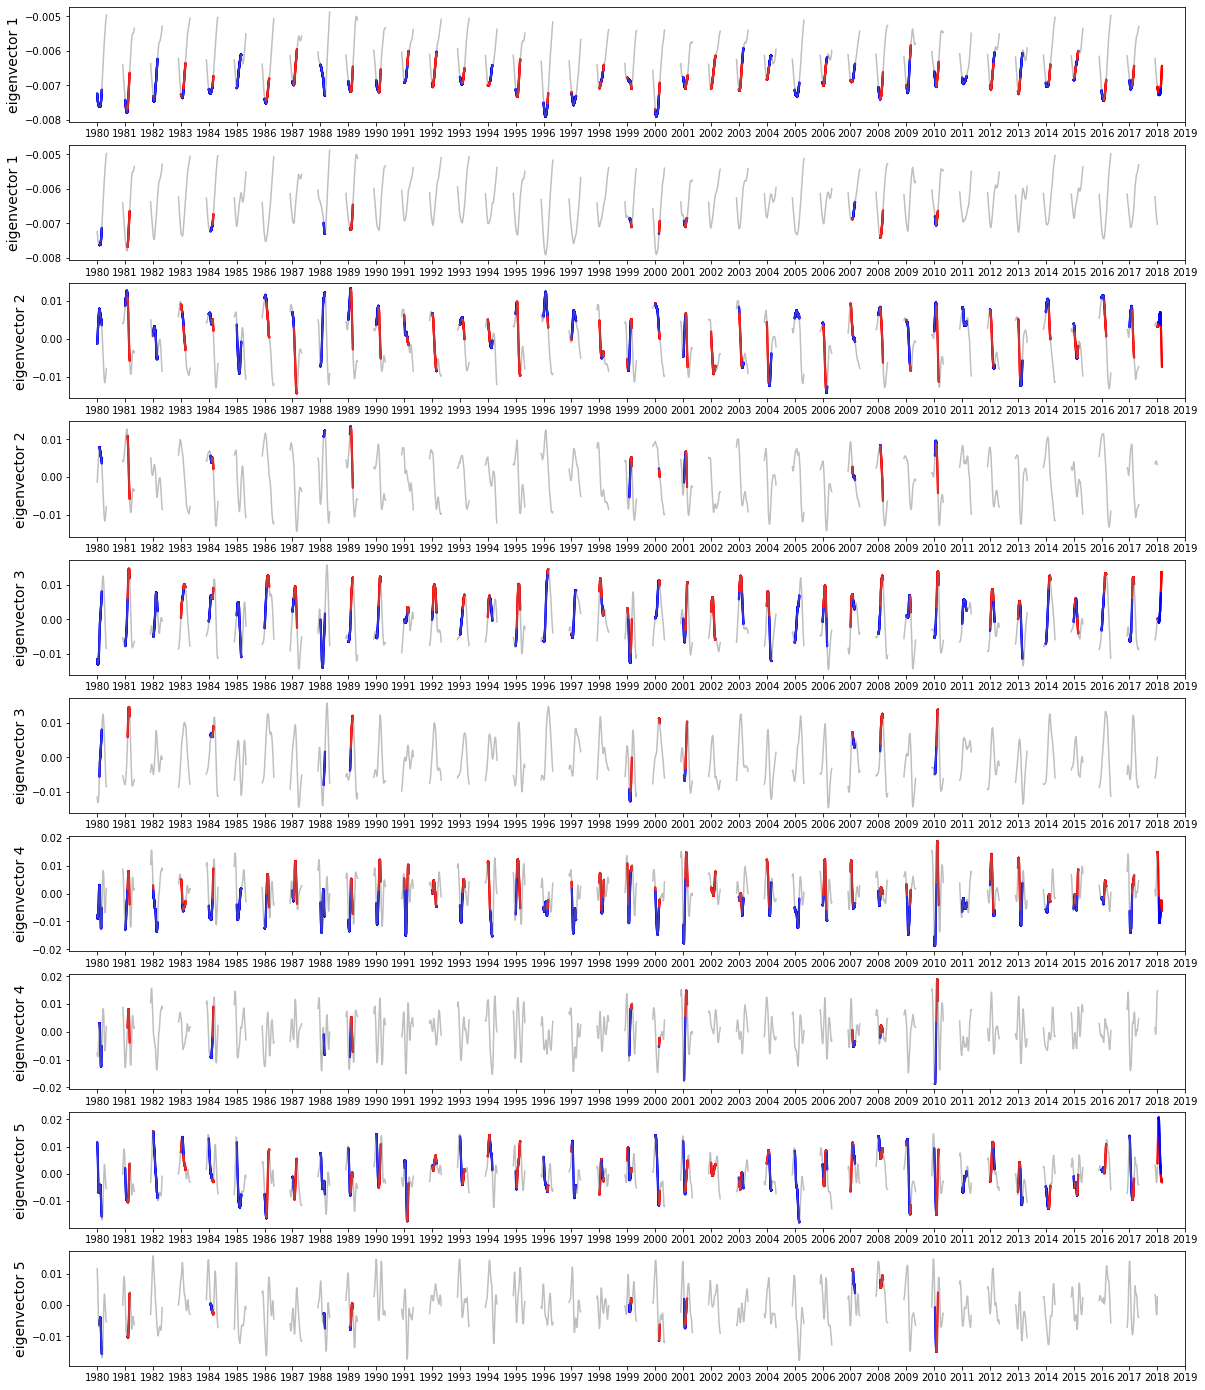

In [36]:
plot_all_eig_clusters(eigv_PCA,jan_feb, colors_lines, traj = traj_30_10)

In [37]:
def plot_all_eig(eigv_time, colors_lines, traj = traj):
    fig, axs = plt.subplots(10, 1, figsize=(25, 25))
    m = 1
    for i in range(10):
        full_winers = pd.date_range('1980-01-01', '2017-12-31', freq = '6H')
        df = pd.DataFrame(index=full_winers,
                          data={
                              m:
                              -eigv_time[m],
                              'cluster_label_spectral_kernel':
                              eigv_time['cluster_label_spectral_kernel']
                          })        
        #axs[i].plot(eigv_time[m], alpha=0.5, color = 'grey')
        axs[i].plot(df[m], alpha=0.5, color = 'grey')
        colors = ['blue', 'red','green']
        #color = {0: 'blue', 1: 'red', 2: 'green'}
        
        for year in traj:
            for el in traj[str(year)]:
                trajectory = eigv_time[m][el[0]]
                type_ = el[1]
                labels = eigv_time.loc[trajectory.index]['cluster_label_spectral_kernel']

                axs[i].plot(trajectory.index,-trajectory.values,
                                    alpha=1,color = colors_lines[type_],
                                    linewidth=0.8)
        axs[i].set_ylabel(f"eigenvector {m}")
        xticks = pd.date_range('1979', '2021', freq='1Y')
        xticks_ = [i.year+1 for i in xticks]
        axs[i].set_xticks(xticks)
        axs[i].set_xticklabels(xticks_)
        axs[i].set_xlim([pd.to_datetime('1979'), pd.to_datetime('2019')])
        m += 1

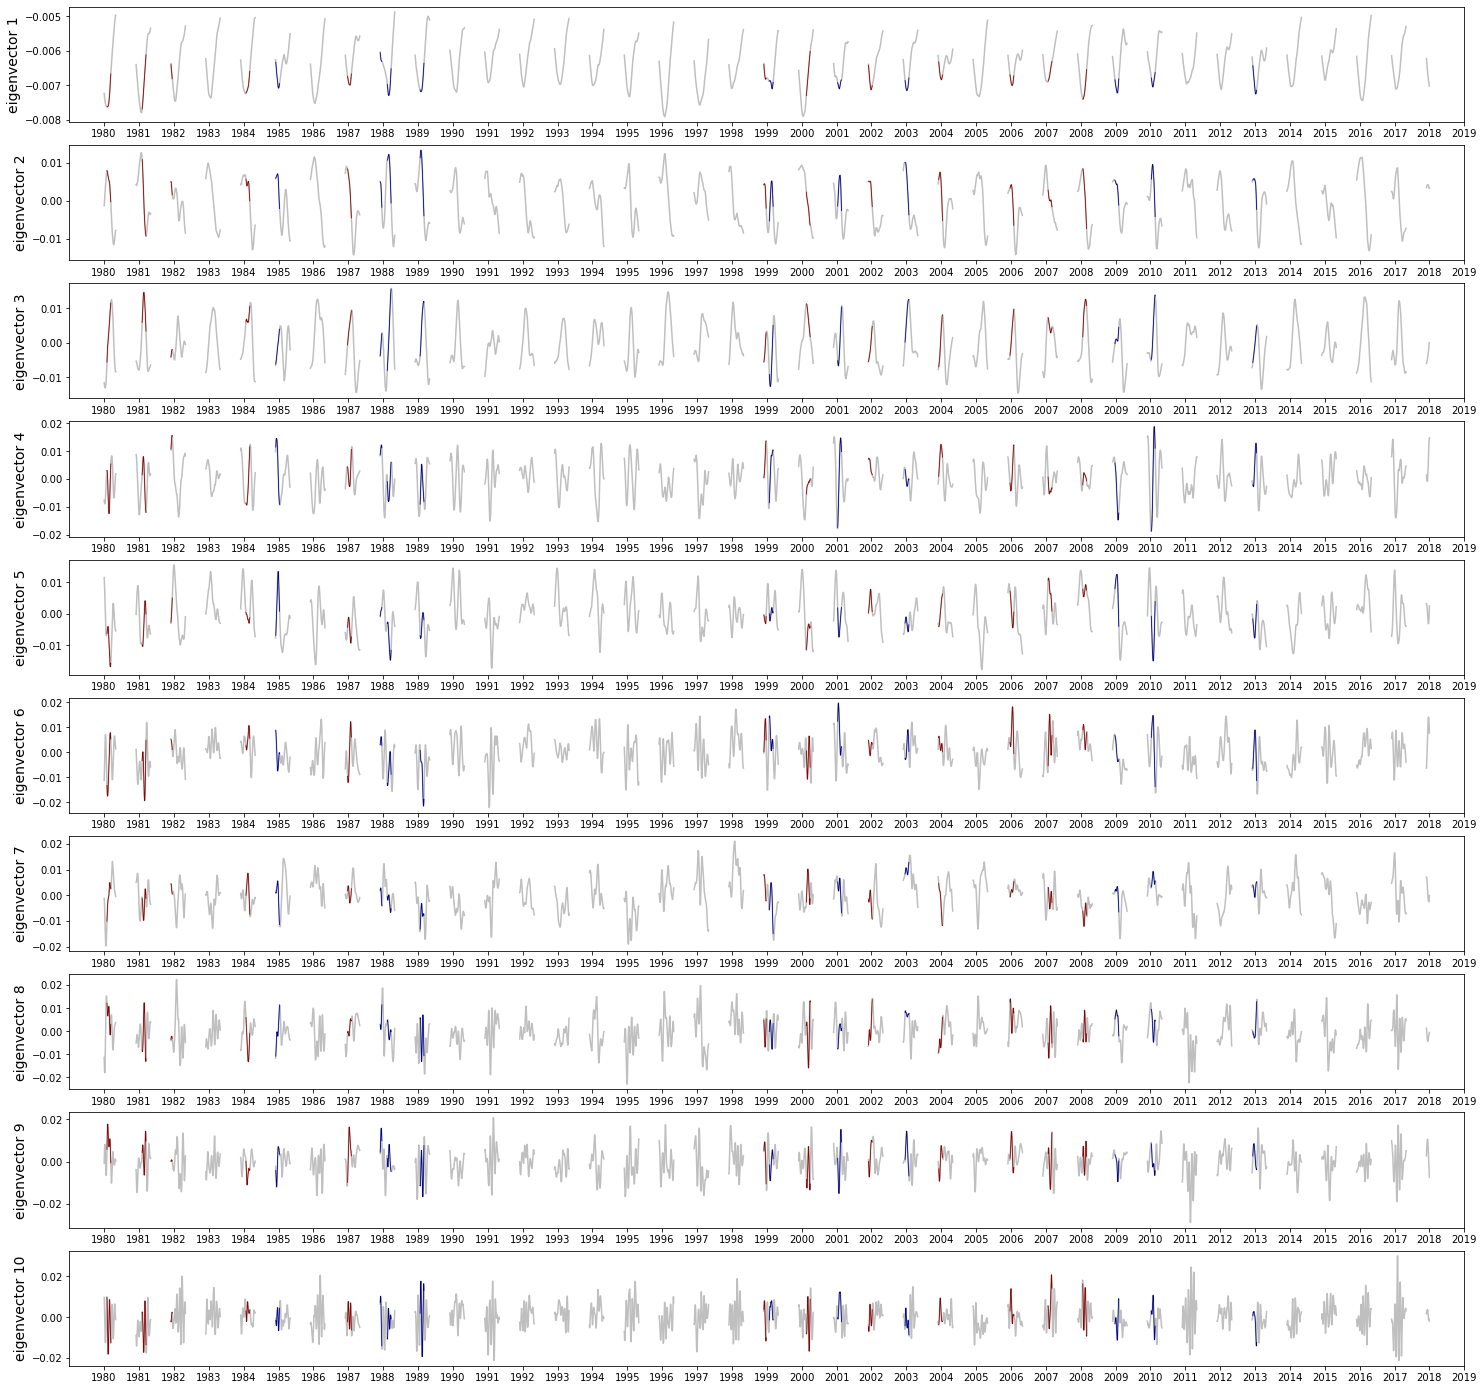

In [38]:
plot_all_eig(eigv_PCA, colors_lines, traj = traj_30_10)

### Average trajectories with and without SSW:

In [39]:
def Diff(li1, li2):
    return (list(list(set(li1) - set(li2)) + list(set(li2) - set(li1))))

winters_S, winters_D, winters_ssw = [], [], []
for d in dates:
    year = pd.to_datetime(d[0]).year
    month = pd.to_datetime(d[0]).month
    type_ = d[1]
    if month < 10 and year not in winters_ssw:
        winters_ssw.append(year - 1)
        if type_ == 'S':
            winters_S.append(year - 1)
        else:
            winters_D.append(year - 1)
    if month >= 10 and year not in winters_ssw:
        winters_ssw.append(year)
        if type_ == 'S':
            winters_S.append(year)
        else:
            winters_D.append(year)
            
winters_ssw = np.unique(np.array(winters_ssw))
winters_S = np.unique(np.array(winters_S))
winters_D = np.unique(np.array(winters_D))

winters_no_ssw = np.sort(Diff(range(1979, 2017, 1), winters_ssw))
print('Winters with SSW:')
print(winters_ssw)
print('Winters with SSW type split:')
print(winters_S)
print('Winters with SSW type displacement:')
print(winters_D)
print('Winters without SSW:')
print(winters_no_ssw)

Winters with SSW:
[1979 1980 1981 1983 1984 1986 1987 1988 1998 1999 2000 2001 2002 2003
 2005 2006 2007 2008 2009 2012]
Winters with SSW type split:
[1984 1987 1988 1998 2000 2002 2008 2009 2012]
Winters with SSW type displacement:
[1979 1980 1981 1983 1986 1998 1999 2001 2003 2005 2006 2007]
Winters without SSW:
[1982 1985 1989 1990 1991 1992 1993 1994 1995 1996 1997 2004 2010 2011
 2013 2014 2015 2016]


In [40]:
def average_traj(eig, winters_years):
    # first winter:
    year = winters_years[0]
    winter_of_that_year = pd.date_range(str(year) + '-12',
                                        str(year + 1) + '-04',
                                        freq='6H')
    winter_eig = eig[winter_of_that_year][:485]

    df = pd.DataFrame(index=transform_date(winter_eig.index)[:485],
                      data={year: winter_eig.values})
    for year in winters_years[1:]:
        winter_of_that_year = pd.date_range(str(year) + '-12',
                                            str(year + 1) + '-04',
                                            freq='6H')
        val = eig[winter_of_that_year][:485].values

        df[year] = eig[winter_of_that_year][:485].values

    return np.mean(df, axis=1), df

In [41]:
def traj_SSW_spring(type_ = 'S', winters_S = winters_S):
    trajectories = []
    for winter in winters_S:
        if str(winter) in traj_30_10:
            for traj in traj_30_10[str(winter)]:
                month_1 = traj[0].month[0]
                # if trajectory of ssw starts before march 
                if month_1 <= 3 and traj[1] in type_:
                    trajectories.append(traj)
    return trajectories

traj_S_spring = traj_SSW_spring(type_ = 'S', winters_S = winters_S)
traj_D_spring = traj_SSW_spring(type_ = 'D', winters_S = winters_D)
traj_ssw_spring = traj_SSW_spring(type_ = ['D','S'], winters_S = winters_ssw)

traj_no_ssw_spring = []
for winter in winters_no_ssw:
    traj_no_ssw_spring.append([
        pd.date_range(str(winter) + '-01', str(winter) + '-04', freq='6H'), 'N'
    ])

In [42]:
def traj_SSW_winter(type_ = 'S', winters_S = winters_S):
    trajectories = []
    for winter in winters_S:
        if str(winter) in traj_30_10:
            for traj in traj_30_10[str(winter)]:
                month_1 = traj[0].month[0]
                # if trajectory of ssw starts before march 
                if month_1 > 4 and traj[1] in type_:
                    trajectories.append(traj)
    return trajectories

traj_S_winter = traj_SSW_winter(type_ = 'S', winters_S = winters_S)
traj_D_winter = traj_SSW_winter(type_ = 'D', winters_S = winters_D)
traj_ssw_winter = traj_SSW_winter(type_ = ['D','S'], winters_S = winters_ssw)

traj_no_ssw_winter = []
for winter in winters_no_ssw:
    traj_no_ssw_winter.append([
        pd.date_range(str(winter) + '-12-01', str(winter) + '-12-31', freq='6H'), 'N'
    ])

In [43]:
def avg_traj_spring(eig, trajectories):
    m = 1
    winter_eig = eig[trajectories[0][0]]
    ind = transform_date(winter_eig.index, special_traj = True)
    test = pd.Series(index = ind, data = winter_eig.values)
    if pd.datetime(1984,2,28) in test.index:
        test.drop(test['1984-02-28'].index, axis = 0, inplace = True)
    df = pd.DataFrame(index = pd.date_range(str(1984) + '-01', str(1984) + '-04',
                                                freq='6H'), data = {1: test})
    n = 2
    for traj in trajectories[1:]: 
        winter_eig = eig[traj[0]]

        ind = transform_date(winter_eig.index, special_traj = True)
        test = pd.Series(index = ind, data = winter_eig.values)
        if pd.datetime(1984,2,28) in test.index:
            test.drop(test['1984-02-28'].index, axis = 0, inplace = True)
        df[n] = test
        n+= 1
    
    return np.mean(df, axis=1), df

In [44]:
def avg_traj_winter(eig, trajectories):
    m = 1
    winter_eig = eig[trajectories[0][0]]
    ind = transform_date(winter_eig.index, special_traj = True)
    test = pd.Series(index = ind, data = winter_eig.values)

    df = pd.DataFrame(index = pd.date_range(str(1983) + '-12-01', str(1983) + '-12-31',
                                                freq='6H'), data = {1: test})
    n = 2
    for traj in trajectories[1:]: 
        winter_eig = eig[traj[0]]

        ind = transform_date(winter_eig.index, special_traj = True)
        test = pd.Series(index = ind, data = winter_eig.values)
        df[n] = test
        n+= 1
    
    return np.mean(df, axis=1), df

In [45]:
def transform_date(column, special_traj=False):
    
    if special_traj:
        new_col = []
        month = column[0].month
        for i in column:
            month = i.month
            day = i.day
            if month < 4:
                if month == 2 and day == 29:
                    new_col.append(
                        datetime(1984, month, day - 1, i.hour, i.minute,
                                 i.second))
                else:
                    new_col.append(
                        datetime(1984, month, day, i.hour, i.minute, i.second))
            else:
                new_col.append(
                    datetime(1983, month, day, i.hour, i.minute, i.second))
    else:
        new_col = []
        year = column[0].year
        for i in column:
            month = i.month
            day = i.day
            if i.year > year:
                if month == 2 and day == 29:
                    new_col.append(
                        datetime(1984, month, day - 1, i.hour, i.minute,
                                 i.second))
                else:
                    new_col.append(
                        datetime(1984, month, day, i.hour, i.minute, i.second))
            else:
                new_col.append(
                    datetime(1983, month, day, i.hour, i.minute, i.second))
    return new_col

### Histograms according to clusters:

In [46]:
def select_years(df, winters):
    winters_ = [str(i) for i in winters]
    df_ = df[winters_[0]]
    for y in winters_[1:]:
        df_ = pd.concat([df_, df[y]], axis=1)
    return df_

df_ssw = select_years(eigv_PCA, winters_ssw)
df_no_ssw = select_years(eigv_PCA, winters_no_ssw)
df_ssw_D = select_years(eigv_PCA, winters_D)
df_ssw_S = select_years(eigv_PCA, winters_S)

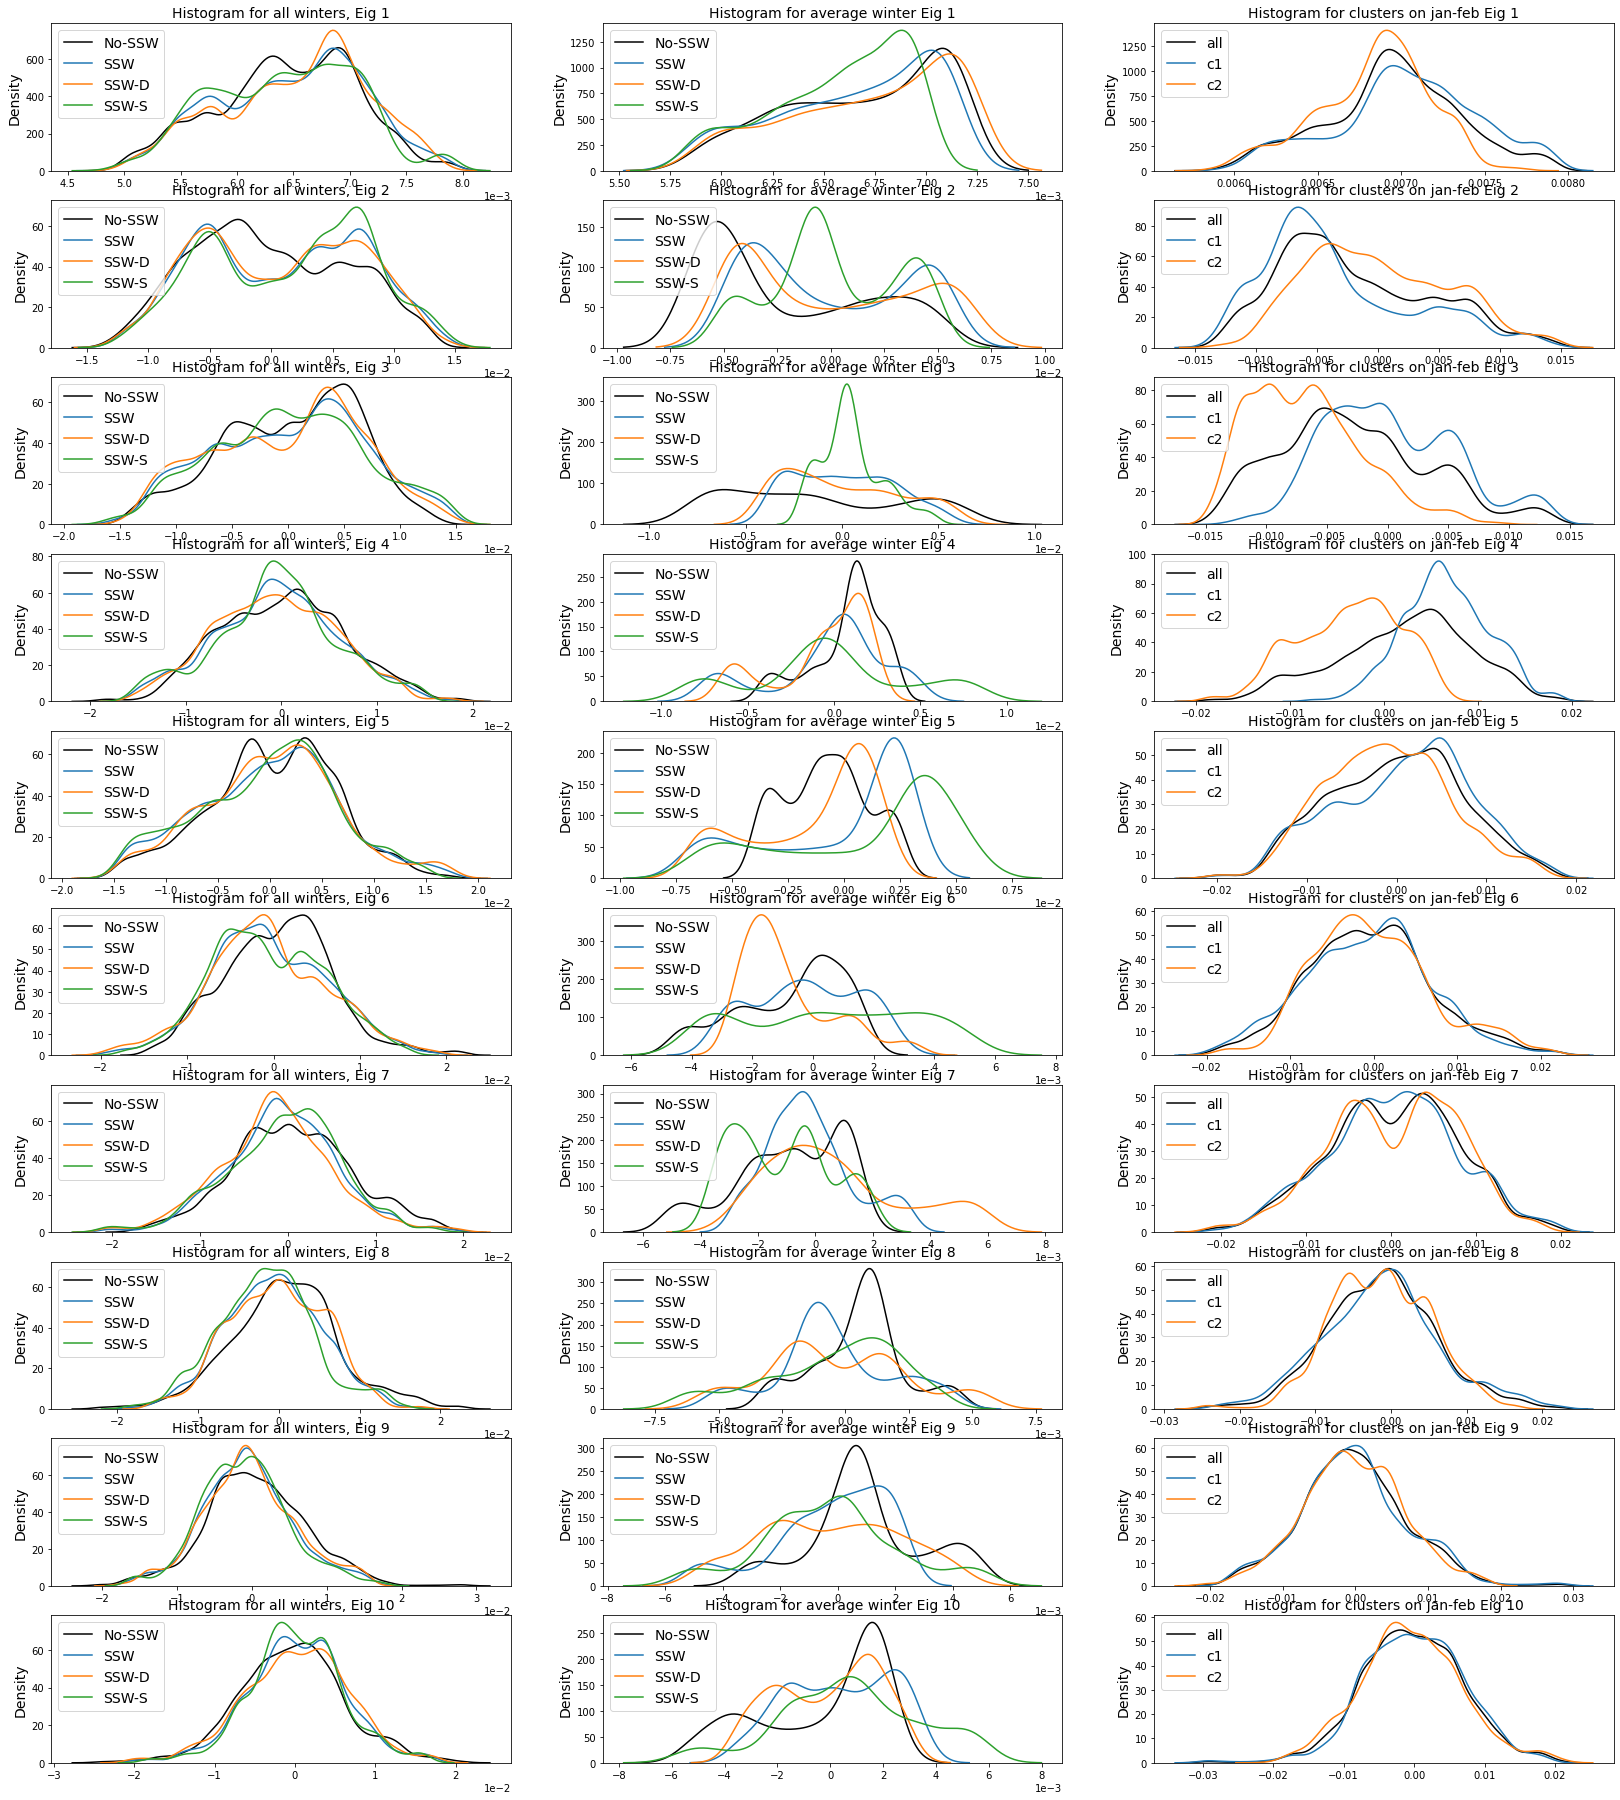

In [47]:
fig, ax = plt.subplots(10, 3, figsize=(28, 32))
m = 1
n = 0
for j in range(10):
    for n in range(3):
        avg_no_ssw, df = average_traj(eigv_PCA[m], winters_no_ssw)
        avg_ssw, df = average_traj(eigv_PCA[m], winters_ssw)
        avg_ssw_D, df = average_traj(eigv_PCA[m], winters_D)
        avg_ssw_S, df = average_traj(eigv_PCA[m], winters_S)
        if n == 0:
            sns.distplot(df_no_ssw[m].values,
                         ax=ax[j, n],
                         label='No-SSW',
                         kde=True,
                         hist=False,color='black')
            sns.distplot(df_ssw[m].values,
                         ax=ax[j, n],
                         label='SSW',
                         kde=True,
                         hist=False)
            sns.distplot(df_ssw_D[m].values,
                         ax=ax[j, n],
                         label='SSW-D',
                         kde=True,
                         hist=False)
            sns.distplot(df_ssw_S[m].values,
                         ax=ax[j, n],
                         label='SSW-S',
                         kde=True,
                         hist=False)
            ax[j, n].set_title(f'Histogram for all winters, Eig {m}')
            ax[j, n].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
            ax[j, n].legend(loc='upper left')
        
        # Plot clusters for january-february period:
        if n == 2:
            c1 = jan_feb[jan_feb['cluster_label_spectral_kernel'] == 0]
            c2 = jan_feb[jan_feb['cluster_label_spectral_kernel'] == 1]
            c3 = jan_feb[jan_feb['cluster_label_spectral_kernel'] == 2]
            sns.distplot(jan_feb[m].values,
                         ax=ax[j, n],
                         label='all',
                         color='black',
                         kde=True,
                         hist=False)
            sns.distplot(c1[m].values,
                         ax=ax[j, n],
                         label='c1',
                         kde=True,
                         hist=False)
            sns.distplot(c2[m].values,
                         ax=ax[j, n],
                         label='c2',
                         kde=True,
                         hist=False)
            sns.distplot(c3[m].values,
                         ax=ax[j, n],
                         label='c3',
                         kde=True,
                         hist=False)
            ax[j, n].set_title(f'Histogram for clusters on jan-feb Eig {m}')
            ax[j, n].legend(loc='upper left')
            m += 1
        
        if n == 1:
            sns.distplot(avg_no_ssw.values,
                         ax=ax[j, n],
                         label='No-SSW',
                         kde=True,
                         hist=False,color='black')
            sns.distplot(avg_ssw.values,
                         ax=ax[j, n],
                         label='SSW',
                         kde=True,
                         hist=False)
            sns.distplot(avg_ssw_D.values,
                         ax=ax[j, n],
                         label='SSW-D',
                         kde=True,
                         hist=False)
            sns.distplot(avg_ssw_S.values,
                         ax=ax[j, n],
                         label='SSW-S',
                         kde=True,
                         hist=False)
            ax[j, n].set_title(f'Eigenvector {m}')
            ax[j, n].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
            ax[j, n].set_title(f'Histogram for average winter Eig {m}')
            ax[j, n].legend(loc='upper left')

### One winter NLSA:

In [48]:
def plot_one_winter_nlsa(eigv_time,sign_mean,
                         year):
    fig, axs = plt.subplots(4, 5, figsize=(23, 20))
    m = 1
    for i in range(4):
        for j in range(5):
            winter_2008 = pd.date_range(str(year) + '-12',
                                        str(year + 1) + '-04',
                                        freq='6H')
            winter_2008_eig_mean = eigv_time[m][winter_2008]

            axs[i, j].plot(winter_2008_eig_mean.index,
                           sign_mean[m] * winter_2008_eig_mean.values,
                           label='heat kernel')
            axs[i, j].set_title(f"Eigenvector {m}")
            axs[i, j].set_xticks((str(year) + '-12', str(year + 1) + '-01',
                                  str(year + 1) + '-02', str(year + 1) + '-03',
                                  str(year + 1) + '-04'))
            axs[i, j].set_xticklabels(['Dec', 'Jan', 'Feb', 'Mar', 'Apr'])
            m += 1
    plt.legend()

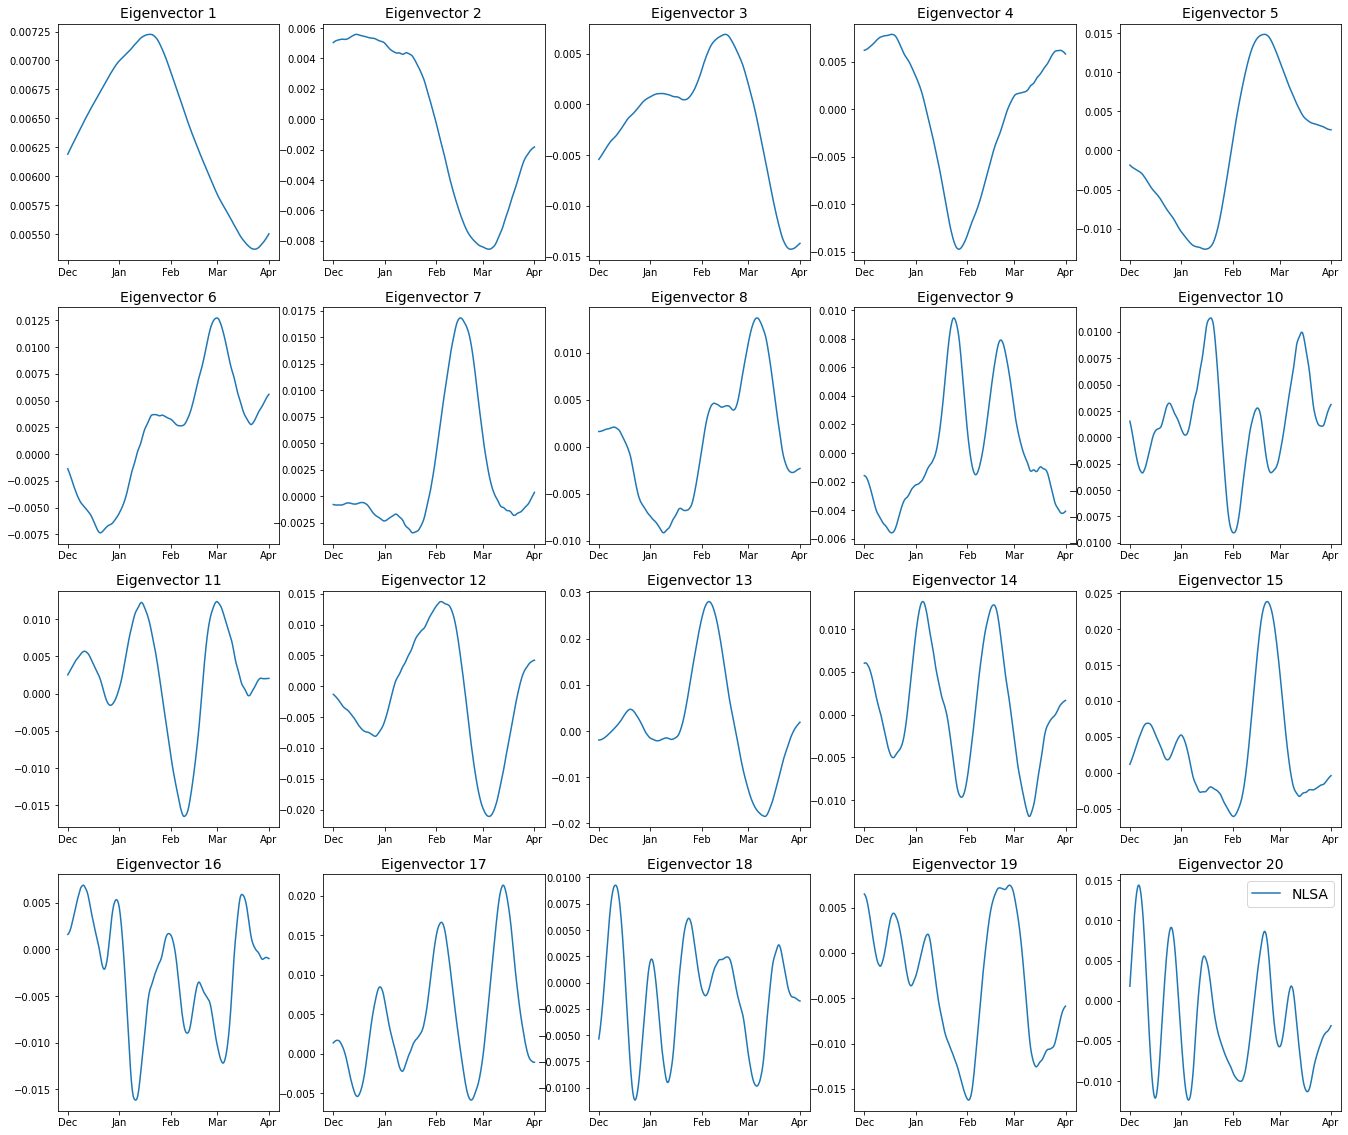

In [49]:
# NLSA versus Laplacian Eigenmaps: 
sign_mean = [0, 1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1]
sign_mean_nlsa = [0, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1]
plot_one_winter_nlsa(eigv_PCA, sign_mean, 2008)
plt.legend(['NLSA', 'Eigenmaps'])

### Individual winters: 

Plot each winter for an eigenvector

In [50]:
def plot_each_winter_nlsa(eigv_time,
                          sign_mean,
                          years,
                          num_eig=1, colors_points = colors_points):
    fig, axs = plt.subplots(10, 4, figsize=(30, 35))
    m = 0
    min_ = np.min(eigv_time[num_eig])
    max_ = np.max(eigv_time[num_eig])
    for i in range(10):
        for j in range(4):
            if m == 39:
                break
            # get winter dates:
            winter = pd.date_range(years[m] + '-12',
                                   years[m + 1] + '-04',
                                   freq='6H')
            # select time series for that winter:
            winter_eig_mean = eigv_time[num_eig][winter]

            axs[i, j].plot(winter_eig_mean.index,
                           sign_mean * winter_eig_mean.values)

            # add end of year dates (Dec):
            if years[m] in years_in_d:
                for el in years_in_d[years[m]]:
                    d_ = el[0]
                    if pd.to_datetime(d_).month > 10:
                        axs[i, j].plot(pd.to_datetime(d_),
                                       sign_mean * winter_eig_mean[d_],
                                       'X',
                                       color=colors_points[el[1]])
                        axs[i, j].annotate(d_[:-9],
                                           (pd.to_datetime(d_),
                                            sign_mean * winter_eig_mean[d_]))
            # add beginning of next year dates (Jan-Apr):
            if years[m + 1] in years_in_d:
                for el in years_in_d[years[m + 1]]:
                    d_ = el[0]
                    if pd.to_datetime(d_).month < 4:
                        axs[i, j].plot(pd.to_datetime(d_),
                                       sign_mean * winter_eig_mean[d_],
                                       'X',
                                       color=colors_points[el[1]])
                        axs[i, j].annotate(d_[:-9],
                                           (pd.to_datetime(d_),
                                            sign_mean * winter_eig_mean[d_]))

            axs[i, j].set_title("Winter " + years[m] + '-' + years[m + 1])
            axs[i, j].set_xticks(
                (years[m] + '-12', years[m + 1] + '-01', years[m + 1] + '-02',
                 years[m + 1] + '-03', years[m + 1] + '-04'))
            axs[i, j].set_xticklabels(['Dec', 'Jan', 'Feb', 'Mar', 'Apr'])

            if sign_mean > 0:
                axs[i, j].set_ylim([min_, max_])
            else:
                axs[i, j].set_ylim([-max_, -min_])
            m += 1

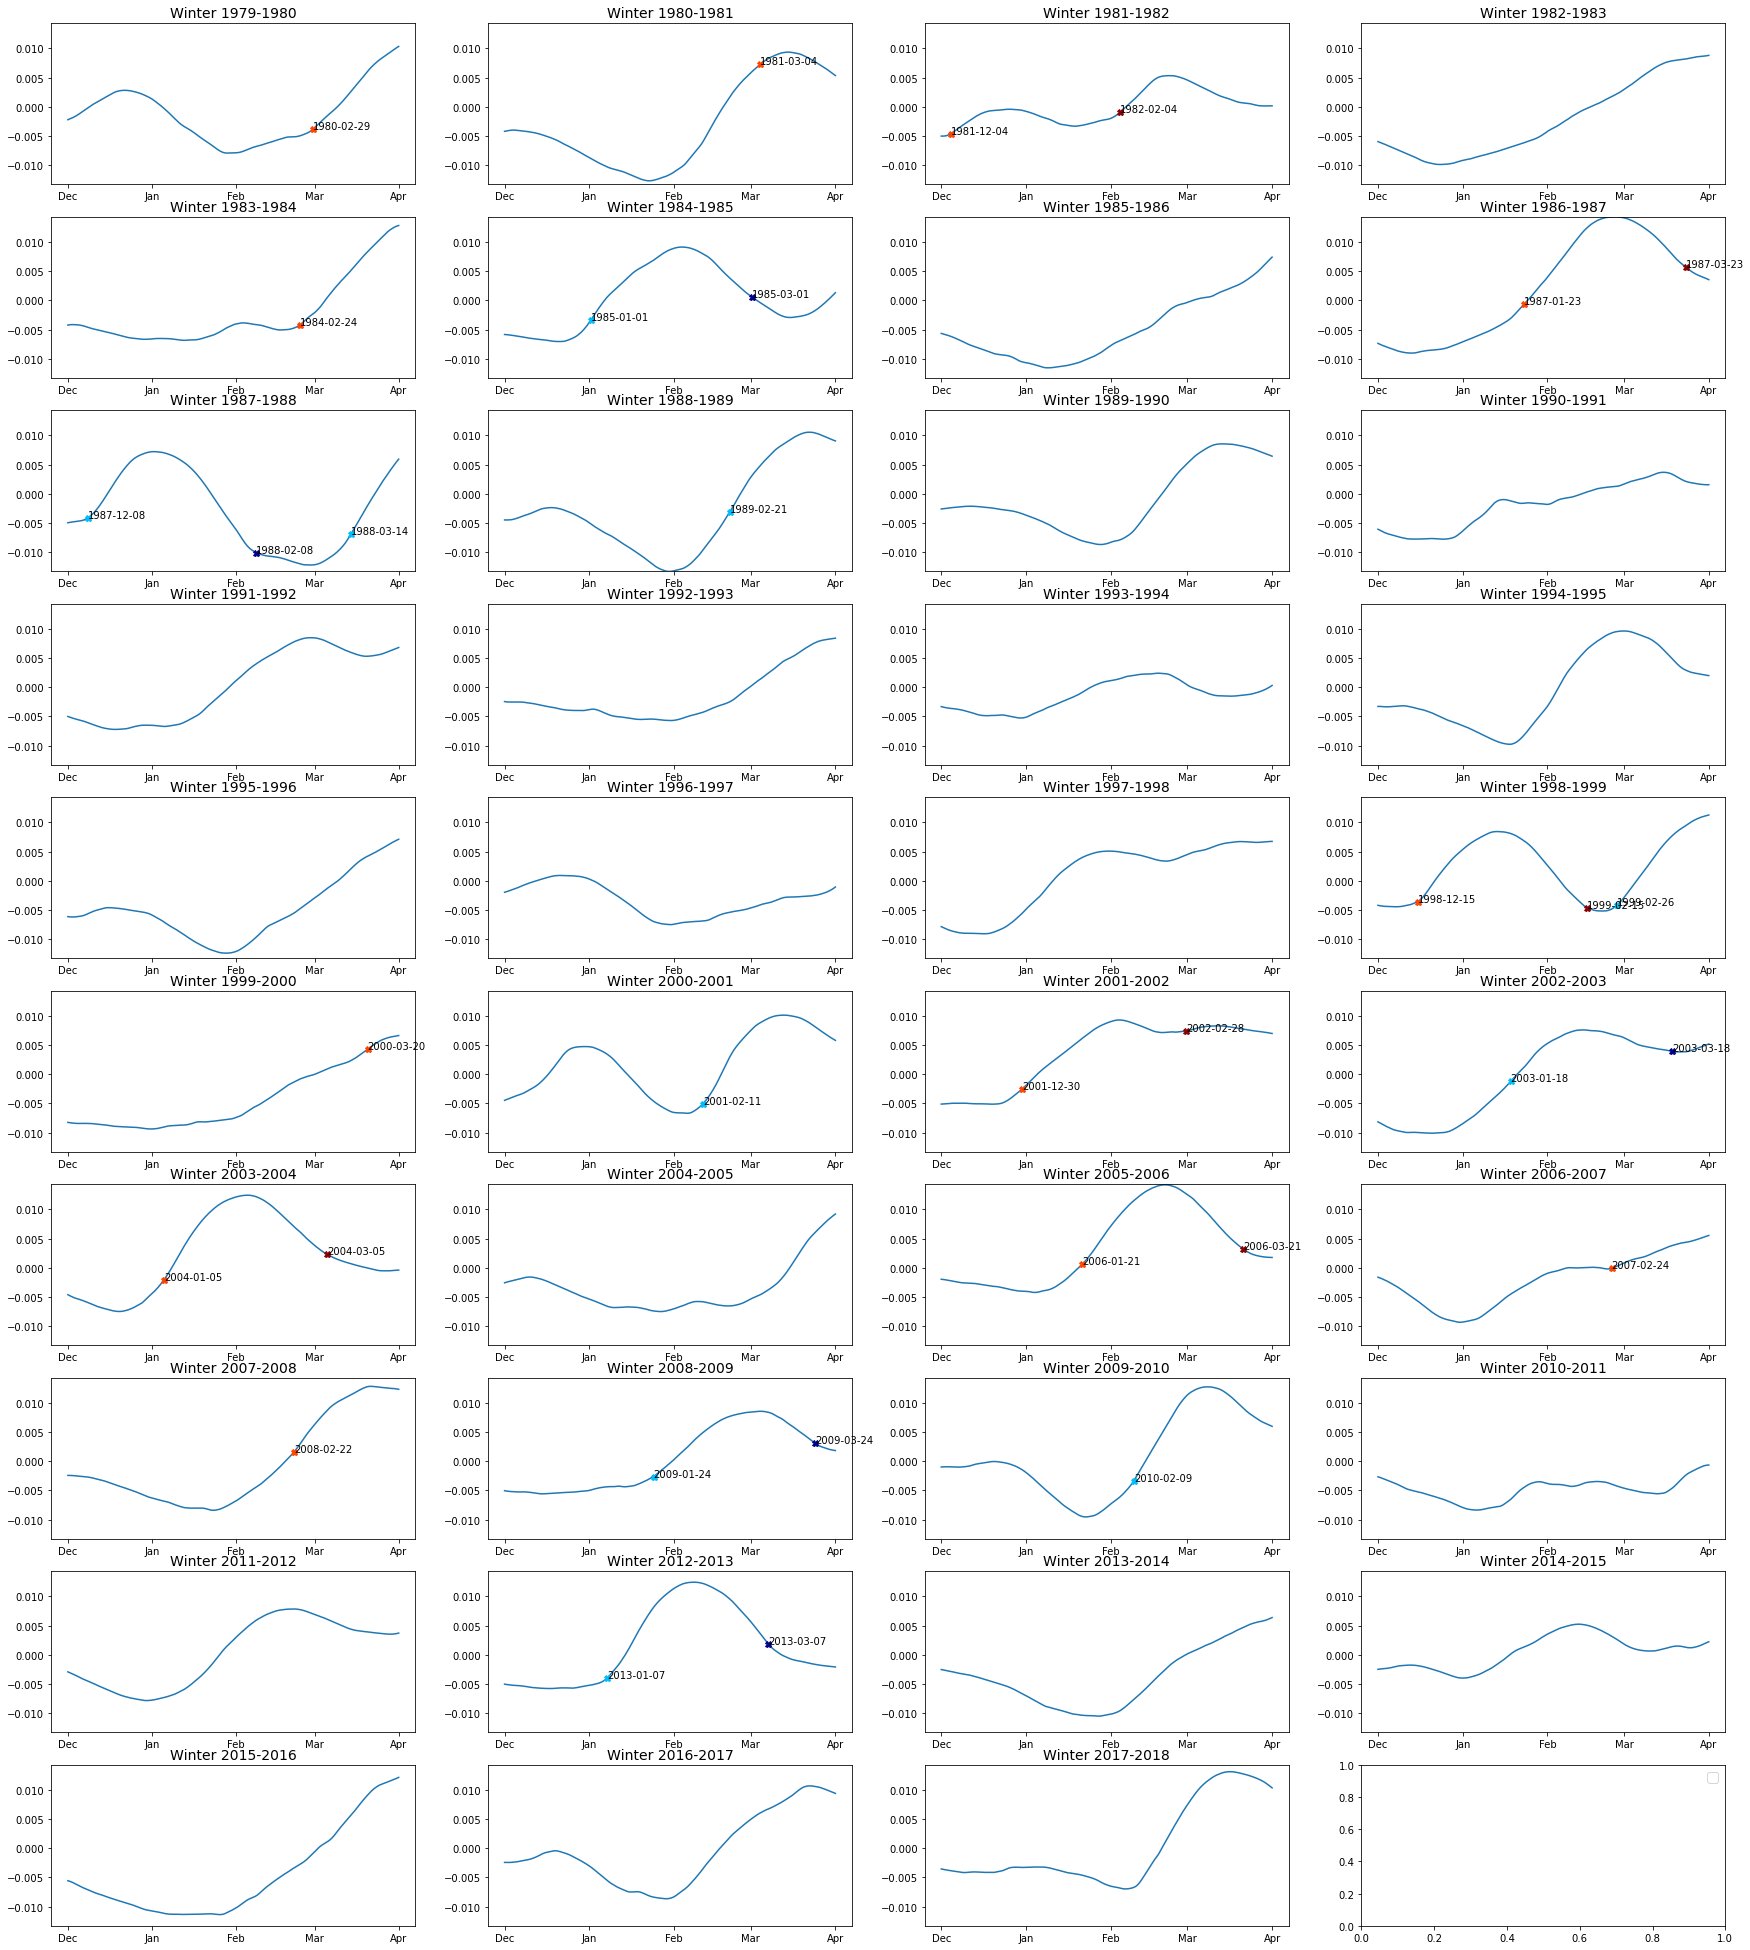

In [51]:
plot_each_winter_nlsa(eigv_PCA, 1,
                       years, num_eig = 2)
plt.legend(['NLSA', 'Eigenmaps'])
#plt.suptitle('NLSA winters for first eigenvector')

### Histograms:

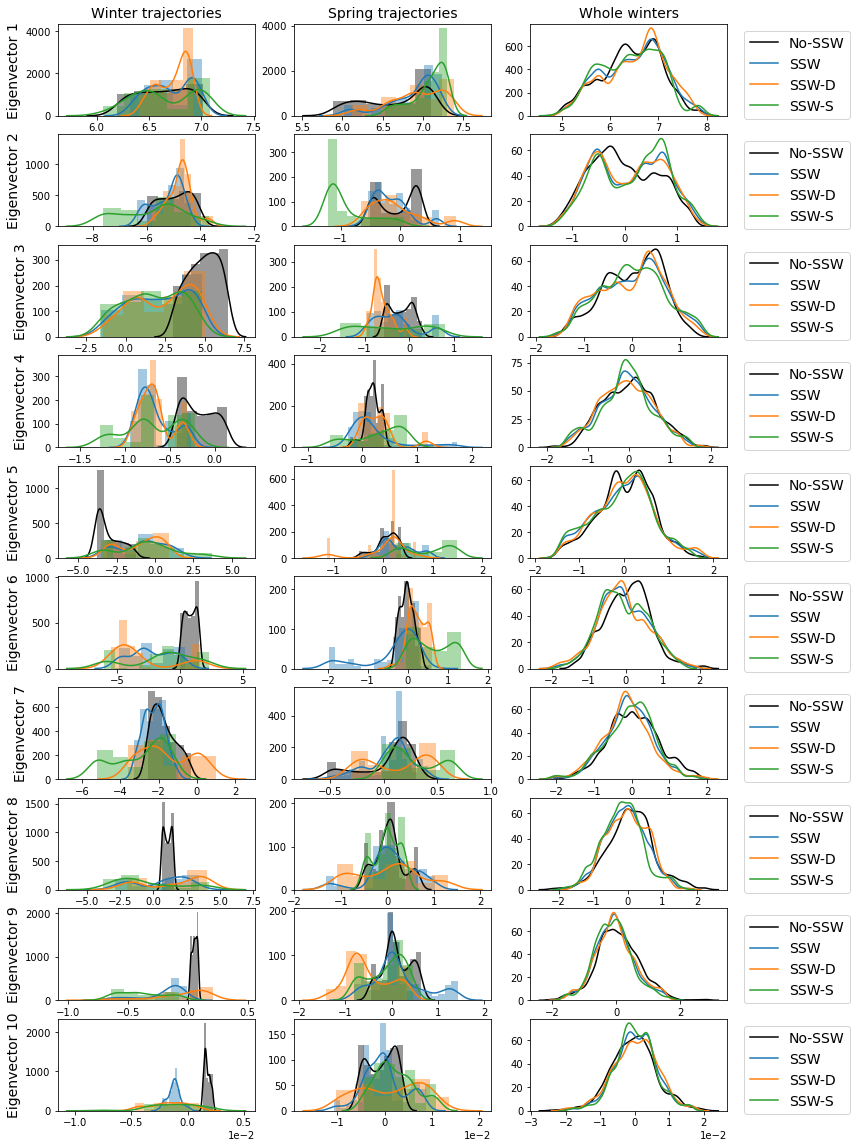

In [52]:
fig, ax = plt.subplots(10, 3, figsize=(12, 20))

m = 1
n = 0
for j in range(10):
    for n in range(3):
        eig = eigv_PCA[m]
        avg_ssw, df = avg_traj_winter(eig, traj_ssw_winter)
        avg_ssw_D, df = avg_traj_winter(eig, traj_D_winter)
        avg_ssw_S, df = avg_traj_winter(eig, traj_S_winter)
        avg_no_ssw, df = avg_traj_winter(eig, traj_no_ssw_winter)

        avg_ssw_spring, df = avg_traj_spring(eig, traj_ssw_spring)
        avg_ssw_D_spring, df = avg_traj_spring(eig, traj_D_spring)
        avg_ssw_S_spring, df = avg_traj_spring(eig, traj_S_spring)
        avg_no_ssw_spring, df = avg_traj_spring(eig, traj_no_ssw_spring)
        
        df_ssw = select_years(eigv_PCA, winters_ssw)
        df_no_ssw = select_years(eigv_PCA, winters_no_ssw)
        df_ssw_D = select_years(eigv_PCA, winters_D)
        df_ssw_S = select_years(eigv_PCA, winters_S)

        if n == 0:
            sns.distplot(avg_no_ssw.values,
                         ax=ax[j, n],
                         color='black',
                         label='No-SSW',
                         kde=True)
            sns.distplot(avg_ssw.values, ax=ax[j, n], label='SSW', kde=True)
            sns.distplot(avg_ssw_D.values,
                         ax=ax[j, n],
                         label='SSW-D',
                         kde=True)
            sns.distplot(avg_ssw_S.values,
                         ax=ax[j, n],
                         label='SSW-S',
                         kde=True)
            if j == 0:
                ax[j, n].set_title(f'Winter trajectories')
            ax[j, n].set_ylabel(f'Eigenvector {m}')
            ax[j, n].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
        if n == 1:
            sns.distplot(avg_no_ssw_spring.values,
                         ax=ax[j, n],
                         color='black',
                         label='No-SSW',
                         kde=True)
            sns.distplot(avg_ssw_spring.values,
                         ax=ax[j, n],
                         label='SSW',
                         kde=True)
            sns.distplot(avg_ssw_D_spring.values,
                         ax=ax[j, n],
                         label='SSW-D',
                         kde=True)
            sns.distplot(avg_ssw_S_spring.values,
                         ax=ax[j, n],
                         label='SSW-S',
                         kde=True)
            if j == 0:
                ax[j, n].set_title(f'Spring trajectories')
            ax[j, n].set_ylabel('')
            ax[j, n].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
        if n == 2:
            """
            ax[j, n].plot(avg_no_ssw.dropna().rolling(window=16).mean(),
                          color='black')
            ax[j, n].plot(avg_ssw.dropna().rolling(window=16).mean(),
                          color='C0')
            ax[j, n].plot(avg_ssw_D.dropna().rolling(window=16).mean(),
                          color='C1')
            ax[j, n].plot(avg_ssw_S.dropna().rolling(window=16).mean(),
                          color='C2')

            ax[j, n].plot(avg_no_ssw_spring.dropna().rolling(window=16).mean(),
                          color='black',
                          label='No-SSW')
            ax[j, n].plot(avg_ssw_spring.dropna().rolling(window=16).mean(),
                          color='C0',
                          label='SSW')
            ax[j, n].plot(avg_ssw_D_spring.dropna().rolling(window=16).mean(),
                          color='C1',
                          label='SSW-D')
            ax[j, n].plot(avg_ssw_S_spring.dropna().rolling(window=16).mean(),
                          color='C2',
                          label='SSW-S')"""
            
            sns.distplot(df_no_ssw[m].values,
                         ax=ax[j, n],
                         label='No-SSW',
                         kde=True,hist = False,color='black')
            sns.distplot(df_ssw[m].values,
                         ax=ax[j, n],
                         label='SSW',
                         kde=True, hist = False)
            sns.distplot(df_ssw_D[m].values,
                         ax=ax[j, n],
                         label='SSW-D',
                         kde=True, hist = False)
            sns.distplot(df_ssw_S[m].values,
                         ax=ax[j, n],
                         label='SSW-S',
                         kde=True, hist = False)
            if j == 0:
                ax[j, n].set_title(f'Whole winters')
            ax[j, n].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
            ax[j, n].legend(loc='upper left')
            ax[j, n].set_ylabel('')
            
            """
            if j == 0:
                ax[j, n].set_title(f'Average trajectory')
            
            ax[j, n].set_xticks(
                ('1983-12', '1984-01', '1984-02', '1984-03', '1984-04'))
            ax[j, n].set_xticklabels(['Dec', 'Jan', 'Feb', 'Mar', 'Apr'])"""
            m += 1
            ax[j, n].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

### Plot overlapping winters:

In [53]:
def transform_d(date, year):
    month = date.month
    day = date.day
    if month == 2 and day == 29:
        return datetime(year, month, day - 1, date.hour, date.minute,
                        date.second)
    else:
        return datetime(year, month, day, date.hour, date.minute, date.second)

In [54]:
def winters_supp(eigv_time,
                 ax,
                 sign,
                 eig,
                 traj,
                 colors_lines,
                 colors,winters_no_ssw, winters_ssw,
                 alpha=0.5,
                 linewidth=1,
                 add_traj=False,
                 y_={
                     2010: 'D',
                     1998: 'D+S',
                     2008: 'S',
                     1990: 'N'
                 }):
    years = eigv_time[eig].index.year.unique()

    n = len(years)
    i = 1
    for year in years[:-1]:
        winter_of_that_year = pd.date_range(str(year) + '-12',
                                            str(year + 1) + '-04',
                                            freq='6H')
        winter_eig = eigv_time[eig][winter_of_that_year]
        ax.plot(transform_date(winter_eig.index),
                sign * winter_eig.values,
                color='grey',
                alpha=alpha,
                linewidth=linewidth)

        """
        # Add dates:
        if str(year) in years_in_d:
            for el in years_in_d[str(year)]:
                d_ = pd.to_datetime(el[0])
                if d_.month >= 12:
                    ax.plot(transform_d(d_, 1983),
                            sign * winter_eig[d_],
                            'x',
                            color=colors[el[1]])
        if str(year + 1) in years_in_d:
            for el in years_in_d[str(year + 1)]:
                d_ = pd.to_datetime(el[0])
                if d_.month < 4:
                    ax.plot(transform_d(d_, 1984),
                            sign * winter_eig[d_],
                            'x',
                            color=colors[el[1]])"""

        if year == 1983:
            ax.set_xticks(
                ('1983-12', '1984-01', '1984-02', '1984-03', '1984-04'))
            ax.set_xticklabels(['Dec', 'Jan', 'Feb', 'Mar', 'Apr'])

        if year in y_:
            ax.plot(transform_date(winter_eig.index),
                    sign * winter_eig.values,
                    color=colors_lines[y_[year]],
                    alpha=0.8,
                    linewidth=linewidth,
                    label=f'{year}-{year+1}: {y_[year]}')
        if add_traj:
            if str(year) in traj:
                for el in traj[str(year)]:
                    trajectory = eigv_time[eig][el[0]]
                    type_ = el[1]
                    ax.plot(transform_date(trajectory.index,
                                           special_traj=True),
                            sign * trajectory.values,
                            color='purple',
                            alpha=0.6,
                            linewidth=0.8)
        
        i += 1
    avg_no_ssw, df = average_traj(eigv_time[eig], winters_no_ssw)

    eig = eigv_time[eig]
    avg_ssw_winter, df = avg_traj_winter(eig, traj_ssw_winter)
    avg_ssw_D_winter, df = avg_traj_winter(eig, traj_D_winter)
    avg_ssw_S_winter, df = avg_traj_winter(eig, traj_S_winter)
    avg_no_ssw_winter, df = avg_traj_winter(eig, traj_no_ssw_winter)
    
    avg_ssw_spring, df = avg_traj_spring(eig, traj_ssw_spring)
    avg_ssw_D_spring, df = avg_traj_spring(eig, traj_D_spring)
    avg_ssw_S_spring, df = avg_traj_spring(eig, traj_S_spring)
    avg_no_ssw_spring, df = avg_traj_spring(eig, traj_no_ssw_spring)
    """
    ax.plot(avg_no_ssw_winter.index,
                sign * avg_no_ssw_winter.values,
                linewidth=1, color = 'black', label = 'NO-SSW')
    ax.plot(avg_no_ssw_spring.index,
                sign * avg_no_ssw_spring.values,
                linewidth=1, color = 'black')
    ax.plot(avg_ssw_winter.index,
                sign * avg_ssw_winter.values,
                linewidth=1, color = colors_points['SSW'], label = 'SSW')
    ax.plot(avg_ssw_spring.index,
                sign * avg_ssw_spring.values,
                linewidth=1, color = colors_points['SSW'])
    ax.plot(avg_ssw_D_winter.index,
                sign * avg_ssw_D_winter.values,
                linewidth=1, color = colors_points['D'], label = 'SSW-D')
    ax.plot(avg_ssw_D_spring.index,
                sign * avg_ssw_D_spring.values,
                linewidth=1, color = colors_points['D'])
    ax.plot(avg_ssw_S_winter.index,
                sign * avg_ssw_S_winter.values,
                linewidth=1, color = colors_points['S'], label = 'SSW-S')
    ax.plot(avg_ssw_S_spring.index,
                sign * avg_ssw_S_spring.values,
                linewidth=1, color = colors_points['S'])"""

    plt.legend(loc='upper left')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Overlapping winters for the first Laplacian eigenmap')

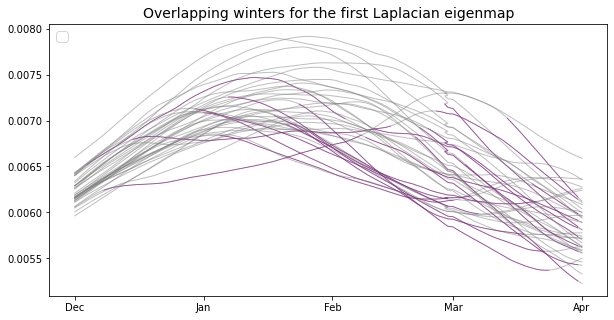

In [55]:
colors_lines ={'S':'darkblue', 'D':'darkred', 'D+S':'darkorange', 'N':'green'}
colors_points = {
    'D': 'purple',
    'D_TM': 'darkred',
    'S': 'deepskyblue',
    'S_TM': 'darkblue', 
    'c1-SSW':'orange', 
    'c2-SSW':'orange',
    'c1-NO-SSW':'limegreen', 
    'c2-NO-SSW':'limegreen',
    'SSW':'red', 
    'NO-SSW': 'darkgreen'
    
}
fig, ax = plt.subplots(1, figsize=(10, 5))
winters_supp(eigv_PCA,
             ax,
             1,
             eig=1,
             traj=traj,
             colors_lines=colors_lines,
             colors=colors_points,
             winters_no_ssw=winters_no_ssw,
             winters_ssw=winters_ssw,
             add_traj=True, y_ = {})
#plt.legend(loc='lower right')
plt.title('Overlapping winters for the first Laplacian eigenmap')

### Multiplot: 

In [56]:
import matplotlib.collections as mcoll
import matplotlib.path as mpath

def colorline(x,
              y,
              ax,
              z=None,
              cmap=plt.get_cmap('copper'),
              norm=plt.Normalize(0.0, 1.0),
              linewidth=3,
              alpha=1.0):
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))
    # Special case if a single number:
    if not hasattr(
            z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])
    z = np.asarray(z)
    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments,
                              array=z,
                              cmap=cmap,
                              norm=norm,
                              linewidth=linewidth,
                              alpha=alpha)
    #ax = plt.gca()
    ax.add_collection(lc)
    return lc

def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

In [57]:
def add_arrow(line, position=None, direction='right', size=15, color=None, num_arrows = 5,linewidth=1, alpha=1):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    min_ = xdata.min()
    max_ = xdata.max()
    if position is None:
        positions = np.linspace(min_, max_, num_arrows)
    # find closest index
    start_inds = [np.argmin(np.absolute(xdata - p)) for p in positions]
    if direction == 'right':
        end_inds = [start_ind + 1 for start_ind in start_inds]
    else:
        end_inds = [start_ind - 1 for start_ind in start_inds]
    for i in range(len(start_inds)):
        if start_inds[i] < len(xdata) and end_inds[i] < len(xdata): 
            line.axes.annotate('',
                               xytext=(xdata[start_inds[i]], ydata[start_inds[i]]),
                               xy=(xdata[end_inds[i]], ydata[end_inds[i]]),
                               arrowprops=dict(arrowstyle="->", color=color, linewidth=linewidth, alpha=alpha),
                               size=size)

In [58]:
eigv_time_mean_nlsa = eigv_PCA
eig_1_nlsa = eigv_time_mean_nlsa[1]
eig_2_nlsa = eigv_time_mean_nlsa[2]
eig_3_nlsa = eigv_time_mean_nlsa[3]
eig_4_nlsa = eigv_time_mean_nlsa[4]
eig_5_nlsa = eigv_time_mean_nlsa[5]

Save eigenvectors for geographical plots in other notebook:

In [59]:
plots_nlsa = [[0], [eig_1_nlsa, eig_2_nlsa], [eig_1_nlsa, eig_3_nlsa],
              [eig_1_nlsa, eig_4_nlsa], [eig_1_nlsa, eig_5_nlsa],
              [eig_2_nlsa, eig_1_nlsa], [0], [eig_2_nlsa, eig_3_nlsa],
              [eig_2_nlsa, eig_4_nlsa], [eig_2_nlsa, eig_5_nlsa],
              [eig_3_nlsa, eig_1_nlsa], [eig_3_nlsa, eig_2_nlsa], [0],
              [eig_3_nlsa, eig_4_nlsa], [eig_3_nlsa, eig_5_nlsa],
              [eig_4_nlsa, eig_1_nlsa], [eig_4_nlsa, eig_2_nlsa],
              [eig_4_nlsa, eig_3_nlsa], [0], [eig_4_nlsa, eig_5_nlsa],
              [eig_5_nlsa, eig_1_nlsa], [eig_5_nlsa, eig_2_nlsa],
              [eig_5_nlsa, eig_3_nlsa], [eig_5_nlsa, eig_4_nlsa], [0]]

#### Multiplot with average trajectories:

In [60]:
def multiplot(eigv_time,
              plots,
              dates_,
              traj,
              colors_lines,
              colors_points,
              winters_no_ssw=winters_no_ssw,
              winters_ssw=winters_ssw):
    fig, axs = plt.subplots(5, 5, figsize=(20, 20))
    m = 0
    y_= {}
    for i in range(5):
        for j in range(5):
            pl = plots[m]
            if i != j:
                #plot grey lines:
                axs[i, j].plot(pl[0],
                               pl[1],
                               alpha=0.8,
                               color='grey',
                               linewidth=0.15)

                # add special trajectories:
                for y in y_:
                    winter_year = pd.date_range(f'{y}-12', f'{y+1}-04')
                    winter_year_eig_0 = pl[0][winter_year]
                    winter_year_eig_1 = pl[1][winter_year]
                    line = axs[i, j].plot(winter_year_eig_0,
                                          winter_year_eig_1,
                                          linewidth=1,
                                          color=colors_lines[y_[y]],
                                          label=f'{y}-{y+1}: {y_[y]}')[0]
                    add_arrow(line)
                
                # add average ssw/no ssw trajectories:
                eig1 = pl[0]
                avg_ssw_winter_1, df = avg_traj_winter(eig1, traj_ssw_winter)
                avg_ssw_D_winter_1, df = avg_traj_winter(eig1, traj_D_winter)
                avg_ssw_S_winter_1, df = avg_traj_winter(eig1, traj_S_winter)
                avg_no_ssw_winter_1, df = avg_traj_winter(eig1, traj_no_ssw_winter)

                avg_ssw_spring_1, df = avg_traj_spring(eig1, traj_ssw_spring)
                avg_ssw_D_spring_1, df = avg_traj_spring(eig1, traj_D_spring)
                avg_ssw_S_spring_1, df = avg_traj_spring(eig1, traj_S_spring)
                avg_no_ssw_spring_1, df = avg_traj_spring(eig1, traj_no_ssw_spring)
                
                eig2 = pl[1]
                avg_ssw_winter_2,df = avg_traj_winter(eig2, traj_ssw_winter)
                avg_ssw_D_winter_2, df = avg_traj_winter(eig2, traj_D_winter)
                avg_ssw_S_winter_2, df = avg_traj_winter(eig2, traj_S_winter)
                avg_no_ssw_winter_2, df = avg_traj_winter(eig2, traj_no_ssw_winter)

                avg_ssw_spring_2, df = avg_traj_spring(eig2, traj_ssw_spring)
                avg_ssw_D_spring_2, df = avg_traj_spring(eig2, traj_D_spring)
                avg_ssw_S_spring_2, df = avg_traj_spring(eig2, traj_S_spring)
                avg_no_ssw_spring_2, df = avg_traj_spring(eig2, traj_no_ssw_spring)
                
                line_no_ssw = axs[i, j].plot(avg_no_ssw_winter_1,
                                          avg_no_ssw_winter_2,
                                          linewidth=1,
                                          color=colors_points['NO-SSW'],
                                          label=f'NO-SSW')[0]
                line_no_ssw = axs[i, j].plot(avg_no_ssw_spring_1,
                                          avg_no_ssw_spring_2,
                                          linewidth=1,
                                          color=colors_points['NO-SSW'])[0]
                
                line_ssw = axs[i, j].plot(avg_ssw_winter_1,
                                          avg_ssw_winter_2,
                                          linewidth=1,
                                          color=colors_points['SSW'],
                                          label=f'SSW')[0]
                
                line_ssw = axs[i, j].plot(avg_ssw_D_winter_1,
                                          avg_ssw_D_winter_2,
                                          linewidth=1,
                                          color=colors_points['D'],
                                          label=f'D')[0]
                
                
                line_ssw = axs[i, j].plot(avg_ssw_S_winter_1,
                                          avg_ssw_S_winter_2,
                                          linewidth=1,
                                          color=colors_points['S'],
                                          label=f'S')[0]
                
                line_ssw = axs[i, j].plot(avg_ssw_S_spring_1,
                                          avg_ssw_S_spring_2,
                                          linewidth=1,
                                          color=colors_points['S'])[0]
                
                line_ssw = axs[i, j].plot(avg_ssw_D_spring_1,
                                          avg_ssw_D_spring_2,
                                          linewidth=1,
                                          color=colors_points['D'])[0]
                
                                
                line_ssw = axs[i, j].plot(avg_ssw_spring_1,
                                          avg_ssw_spring_2,
                                          linewidth=1,
                                          color=colors_points['SSW'])[0] 
                for year in traj:
                    if int(year) not in y_ and int(year) - 1 not in y_:
                        for el in traj[year]:
                            type_ = el[1]
                            winter_year_eig_0 = pl[0][el[0]]
                            winter_year_eig_1 = pl[1][el[0]]
                            line = axs[i, j].plot(winter_year_eig_0,
                                                  winter_year_eig_1,
                                                  linewidth=0.8,
                                                  color='purple',
                                                  alpha=0.2)[0]
                            add_arrow(line,
                                      num_arrows=3,
                                      linewidth=0.8,
                                      alpha=0.2)
                axs[i, j].locator_params(axis='x', nbins=3)
            else:
                # diagonal plots
                winters_supp(eigv_time,
                             axs[i, j],
                             -1,
                             i + 1,
                             alpha=0.4,
                             linewidth=1,
                             traj=traj,
                             colors_lines=colors_lines,
                             winters_no_ssw=winters_no_ssw,
                             winters_ssw=winters_ssw,
                             colors=colors_points,y_ = y_,
                             add_traj=True)
            if i == 0:
                axs[i, j].set_title(j + 1)
            if j == 0:
                axs[i, j].set_ylabel(i + 1)
            if j == 3 and i == 2:
                plt.rc('legend', fontsize=12)
                axs[i, j].legend(loc='lower right')
            m += 1

    plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


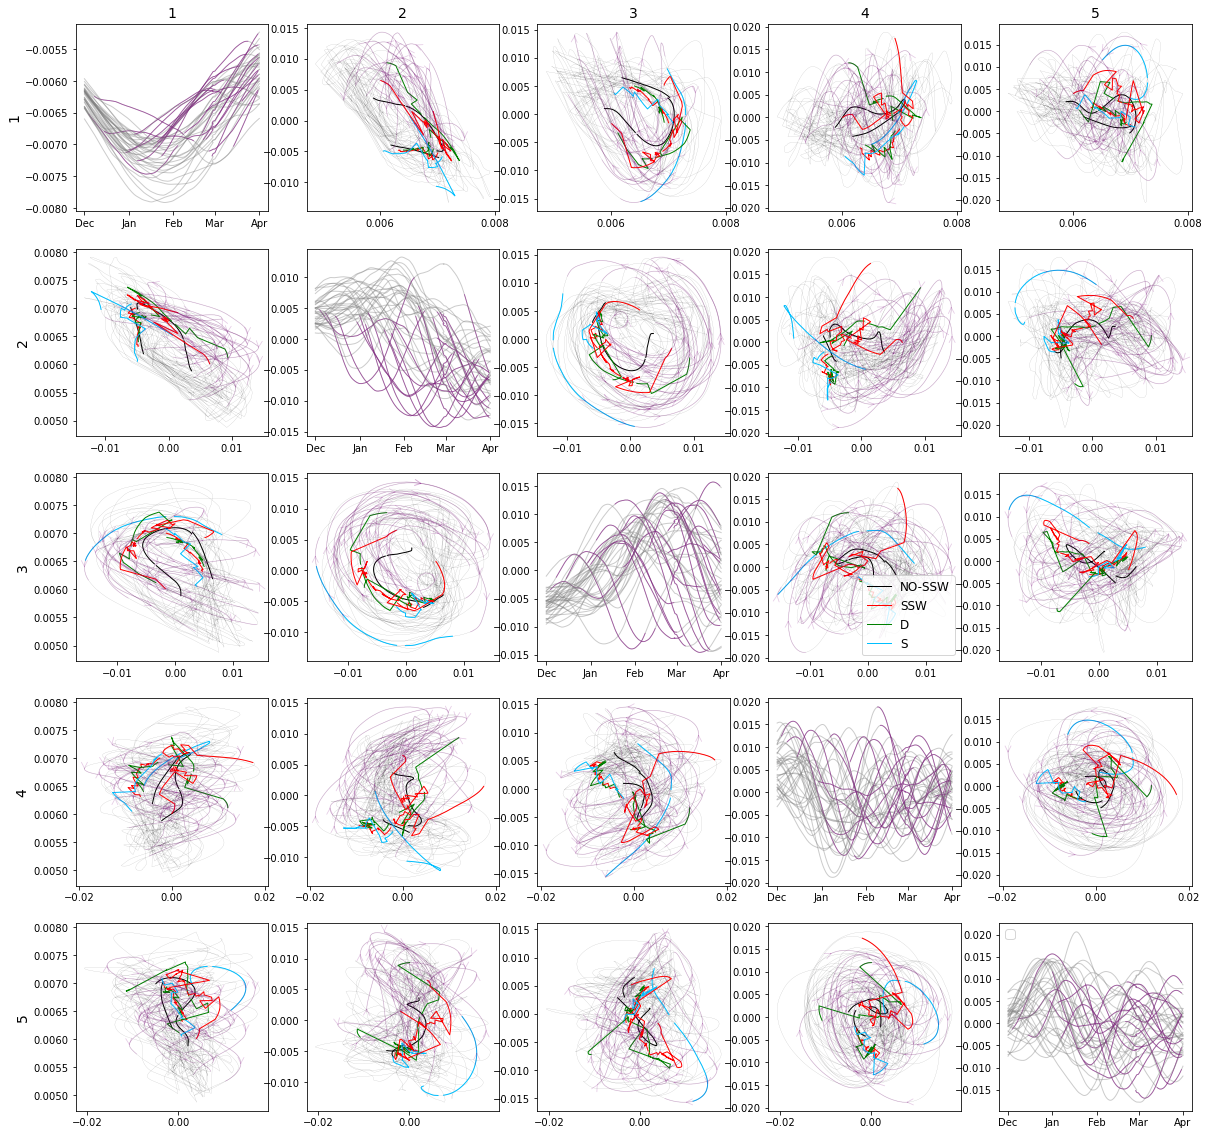

In [61]:
colors_lines ={'S':'darkblue', 'D':'darkred', 'D+S':'darkorange', 'N':'green'}
colors_points = {
    'D': 'green',
    'D_TM': 'darkgreen',
    'S': 'deepskyblue',
    'S_TM': 'darkblue', 
    'SSW':'red', 
    'NO-SSW': 'black'
    
}
multiplot(eigv_time_mean_nlsa, plots_nlsa,dates_,traj,colors_lines, colors_points);

#### Multiplot with all ssw:

In [62]:
def multiplot_allssw(eigv_time,
              plots,
              dates_,
              traj,
              colors_lines,
              colors_points,
              winters_no_ssw=winters_no_ssw,
              winters_ssw=winters_ssw):
    fig, axs = plt.subplots(5, 5, figsize=(20, 20))
    m = 0
    y_= {}
    for i in range(5):
        for j in range(5):
            pl = plots[m]
            if i != j:
                #plot grey lines:
                axs[i, j].plot(pl[0],
                               pl[1],
                               alpha=0.8,
                               color='grey',
                               linewidth=0.15)
                
                """# add average ssw/no ssw trajectories:
                avg_no_ssw_0,df = average_traj(pl[0], winters_no_ssw)
                avg_no_ssw_1,df = average_traj(pl[1], winters_no_ssw)
                
                avg_ssw_0,df = average_traj(pl[0], winters_ssw)
                avg_ssw_1,df = average_traj(pl[1], winters_ssw)
                
                avg_ssw_0_D,df = average_traj(pl[0], winters_D)
                avg_ssw_1_D,df = average_traj(pl[1], winters_D)
                
                avg_ssw_0_S,df = average_traj(pl[0], winters_S)
                avg_ssw_1_S,df = average_traj(pl[1], winters_S)
                
                line_no_ssw = axs[i, j].plot(avg_no_ssw_0,
                                          avg_no_ssw_1,
                                          linewidth=1,
                                          color=colors_points['NO-SSW'],
                                          label=f'NO-SSW')[0]
                add_arrow(line_no_ssw)
                
                line_ssw = axs[i, j].plot(avg_ssw_0,
                                          avg_ssw_1,
                                          linewidth=1,
                                          color=colors_points['SSW'],
                                          label=f'SSW')[0]
                add_arrow(line_ssw)
                line_ssw = axs[i, j].plot(avg_ssw_0_D,
                                          avg_ssw_1_D,
                                          linewidth=1,
                                          color=colors_points['D'],
                                          label=f'SSW-D')[0]
                add_arrow(line_ssw)
                line_ssw = axs[i, j].plot(avg_ssw_0_S,
                                          avg_ssw_1_S,
                                          linewidth=1,
                                          color=colors_points['S'],
                                          label=f'SSW-S')[0]
                add_arrow(line_ssw)"""
                
                # add trajectories
                for year in traj:
                    if int(year) not in y_ and int(year) - 1 not in y_:
                        for el in traj[year]:
                            #type_ = el[1]
                            type_ = 'D'
                            winter_year_eig_0 = pl[0][el[0]]
                            winter_year_eig_1 = pl[1][el[0]]
                            line = axs[i, j].plot(winter_year_eig_0,
                                                  winter_year_eig_1,
                                                  linewidth=0.8,
                                                  color=colors_points[type_],
                                                  alpha=0.6)[0]
                            add_arrow(line,
                                      num_arrows=3,
                                      linewidth=0.8,
                                      alpha=0.5)
                axs[i, j].locator_params(axis='x', nbins=3)

            else:
                # diagonal plots
                winters_supp(eigv_time,
                             axs[i, j],
                             -1,
                             i + 1,
                             alpha=0.4,
                             linewidth=1,
                             traj=traj,
                             colors_lines=colors_lines,
                             winters_no_ssw=winters_no_ssw,
                             winters_ssw=winters_ssw,
                             colors=colors_points,y_ = y_,
                             add_traj=True)
            if i == 0:
                axs[i, j].set_title(j + 1)
            if j == 0:
                axs[i, j].set_ylabel(i + 1)
            if j == 3 and i == 2:
                plt.rc('legend', fontsize=12)
                axs[i, j].legend(loc='lower right')
            m += 1

    plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


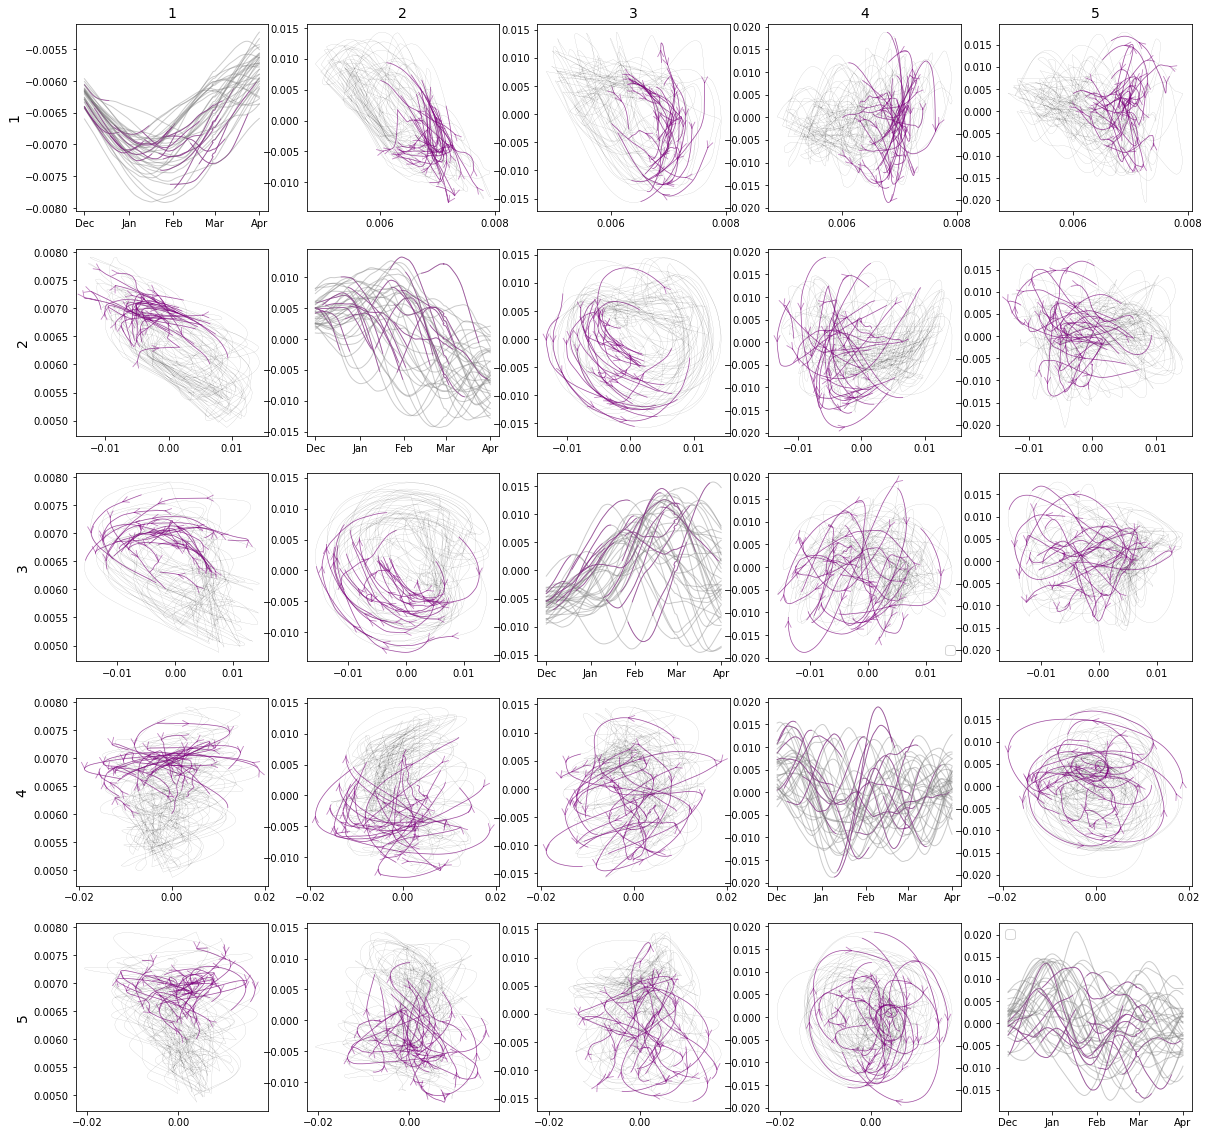

In [63]:
colors_lines ={'S':'darkblue', 'D':'darkred', 'D+S':'darkorange', 'N':'green'}
colors_points = {
    'D': 'purple',
    'D_TM': 'darkred',
    'S': 'deepskyblue',
    'S_TM': 'darkblue', 
    'SSW':'red', 
    'NO-SSW': 'black'
    
}

multiplot_allssw(eigv_time_mean_nlsa, plots_nlsa,dates_,traj_30_10,colors_lines, colors_points);

#### Multiplot with clusters:

In [64]:
time_series = plots_nlsa[1][0].loc[jan_feb['cluster_label_spectral_kernel'].index]

clusters = jan_feb['cluster_label_spectral_kernel'].loc[time_series.index].values
LABEL_COLOR_MAP = {0 : 'red',
                   1 : 'green',
                   2:'blue',
                   }
label_color = [LABEL_COLOR_MAP[l] for l in clusters]

In [65]:
def multiplot_clusters(eigv_time,
              plots,
              dates_,
              traj,
              colors_lines,
              colors_points,
              winters_no_ssw=winters_no_ssw,
              winters_ssw=winters_ssw):
    fig, axs = plt.subplots(5, 5, figsize=(20, 20))
    m = 0
    y_= {}
    for i in range(5):
        for j in range(5):
            pl = plots[m]
            if i != j:
                #plot grey lines:
                axs[i, j].plot(pl[0],
                               pl[1],
                               alpha=0.8,
                               color='grey',
                               linewidth=0.15)
                
                time_series1 = pl[0].loc[jan_feb['cluster_label_spectral_kernel'].index]
                time_series2 = pl[1].loc[jan_feb['cluster_label_spectral_kernel'].index]
                clusters = jan_feb['cluster_label_spectral_kernel'].loc[time_series.index].values
                LABEL_COLOR_MAP = {0 : 'red',
                                   1 : 'green',
                                   2:'blue',
                                   }

                label_color = [LABEL_COLOR_MAP[l] for l in clusters]
                axs[i, j].scatter(time_series1,
                               time_series2,
                               alpha=0.3,
                               c=label_color,s=2,
                               linewidth=0.15)

                # add special trajectories:
                for y in y_:
                    winter_year = pd.date_range(f'{y}-12', f'{y+1}-04')
                    winter_year_eig_0 = pl[0][winter_year]
                    winter_year_eig_1 = pl[1][winter_year]
                    line = axs[i, j].plot(winter_year_eig_0,
                                          winter_year_eig_1,
                                          linewidth=1,
                                          color=colors_lines[y_[y]],
                                          label=f'{y}-{y+1}: {y_[y]}')[0]
                    add_arrow(line)
                
                
                for year in traj:
                    if int(year) not in y_ and int(year) - 1 not in y_:
                        for el in traj[year]:
                            type_ = el[1]
                            winter_year_eig_0 = pl[0][el[0]]
                            winter_year_eig_1 = pl[1][el[0]]
                            line = axs[i, j].plot(winter_year_eig_0,
                                                  winter_year_eig_1,
                                                  linewidth=0.8,
                                                  color='purple',
                                                  alpha=0.2)[0]
                            add_arrow(line,
                                      num_arrows=3,
                                      linewidth=0.8,
                                      alpha=0.2)
                axs[i, j].locator_params(axis='x', nbins=3)

            else:
                # diagonal plots
                winters_supp(eigv_time,
                             axs[i, j],
                             -1,
                             i + 1,
                             alpha=0.4,
                             linewidth=1,
                             traj=traj,
                             colors_lines=colors_lines,
                             winters_no_ssw=winters_no_ssw,
                             winters_ssw=winters_ssw,
                             colors=colors_points,y_ = y_,
                             add_traj=False)
            if i == 0:
                axs[i, j].set_title(j + 1)
            if j == 0:
                axs[i, j].set_ylabel(i + 1)
            if j == 3 and i == 2:
                plt.rc('legend', fontsize=12)
                axs[i, j].legend(loc='lower right')
            m += 1

    plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


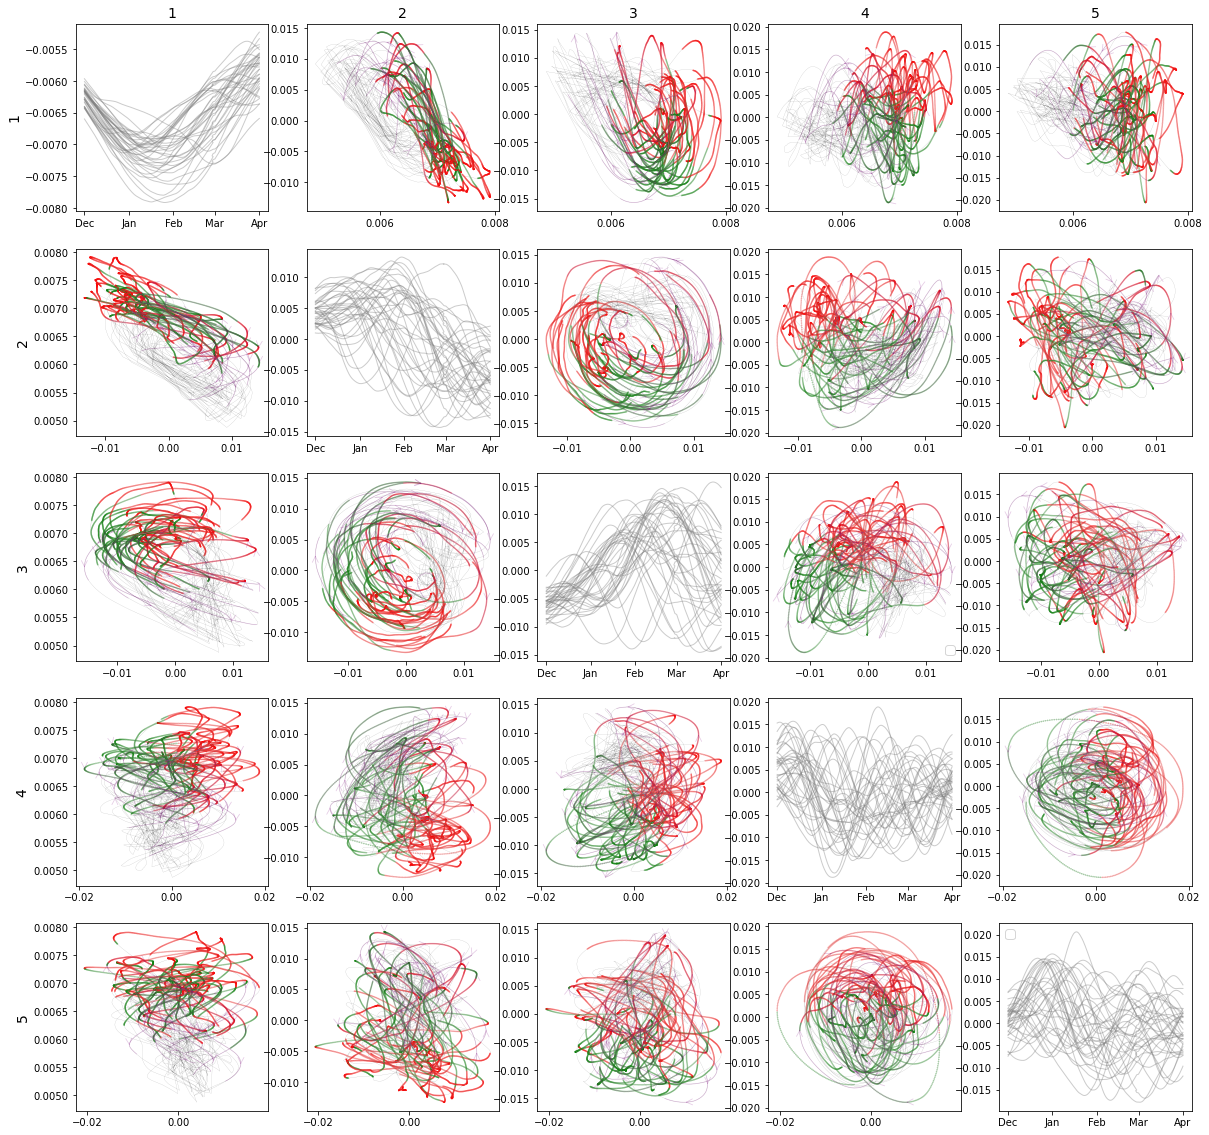

In [66]:
multiplot_clusters(eigv_time_mean_nlsa, plots_nlsa,dates_,traj,colors_lines, colors_points);

### Amplitude:

In [ ]:
def calculate_ampl(eig_1,eig_2):
    r = np.sqrt(np.real(eig_1.values)**2 + np.real(eig_2.values**2))
    amplitude = pd.Series(r, index = eig_1.index)
    return amplitude

In [ ]:
# plot overlapping amplitudes:
def ampl_supp(eig1,
              eig2,
              ax,
              sign,
              traj,
              colors_lines=colors_lines,
              colors=colors_points,
              alpha=0.5,
              linewidth=1,
              add_traj=False,
              y_={
                  2010: 'D',
                  1998: 'D+S',
                  2008: 'S',
                  1990: 'N'
              }):
    amplitude = calculate_ampl(eig1, eig2)
    years = amplitude.index.year.unique()
    n = len(years)
    i = 1
    for year in years[:-1]:
        winter_of_that_year = pd.date_range(str(year) + '-12',
                                            str(year + 1) + '-04',
                                            freq='6H')
        winter_ampl = amplitude[winter_of_that_year]
        ax.plot(transform_date(winter_ampl.index),
                sign * winter_ampl.values,
                color='grey',
                alpha=alpha,
                linewidth=linewidth)

        # Add dates:
        if str(year) in years_in_d:
            for el in years_in_d[str(year)]:
                d_ = pd.to_datetime(el[0])
                if d_.month >= 12:
                    ax.plot(transform_d(d_, 1983),
                            sign * winter_ampl[d_],
                            'x',
                            color=colors[el[1]])
        if str(year + 1) in years_in_d:
            for el in years_in_d[str(year + 1)]:
                d_ = pd.to_datetime(el[0])
                if d_.month < 4:
                    ax.plot(transform_d(d_, 1984),
                            sign * winter_ampl[d_],
                            'x',
                            color=colors[el[1]])
        # special trajectories:
        if year in y_:
            ax.plot(transform_date(winter_ampl.index),
                    sign * winter_ampl.values,
                    color=colors_lines[y_[year]],
                    alpha=0.8,
                    linewidth=linewidth,
                    label=f'{year}-{year+1}: {y_[year]}')

        if add_traj:
            if str(year) in traj and year not in y_:
                for el in traj[str(year)]:
                    trajectory = amplitude[el[0]]
                    type_ = el[1]
                    ax.plot(transform_date(trajectory.index,
                                           special_traj=True),
                            sign * trajectory.values,
                            color=colors[type_],
                            alpha=0.5,
                            linewidth=0.8)

        if year == 1983:
            ax.set_xticks(
                ('1983-12', '1984-01', '1984-02', '1984-03', '1984-04'))
            ax.set_xticklabels(['Dec', 'Jan', 'Feb', 'Mar', 'Apr'])
        i += 1
    plt.legend(loc='upper left')

In [ ]:
fig, ax = plt.subplots(1)
ampl_supp(eigv_time_mean_nlsa[1],eigv_time_mean_nlsa[2], ax, 1, traj = traj, add_traj =True)

In [ ]:
def multiplot_amplitude(eigv_time, plots, dates_, traj, colors_lines,
                        colors_points):
    fig, axs = plt.subplots(5, 5, figsize=(20, 20))
    m = 0
    for i in range(5):
        for j in range(5):

            #y_= {2010:'D', 1998:'D+S', 2008:'S', 1990:'N'}
            y_ = {1990: 'N'}
            pl = plots[m]
            if j > i:
                amplitude = calculate_ampl(pl[0], pl[1])
                ampl_supp(pl[0],
                          pl[1],
                          axs[i, j],
                          1,
                          alpha=0.4,
                          linewidth=1,
                          colors_lines=colors_lines,
                          colors=colors_points,
                          traj=traj,
                          add_traj=True,
                          y_=y_)
                axs[i, j].locator_params(axis='x', nbins=3)

            if j == i:
                # diagonal plots
                winters_supp(eigv_time,
                             axs[i, j],
                             -1,
                             i + 1,
                             alpha=0.4,
                             linewidth=1,
                             traj=traj,
                             colors_lines=colors_lines,
                             colors=colors_points,
                             add_traj=True,
                             y_=y_)
            if j < i:
                #plot grey lines:
                axs[i, j].plot(pl[0],
                               pl[1],
                               alpha=0.8,
                               color='grey',
                               linewidth=0.15)
                # add special dates:
                for el in dates_[1:]:
                    d_ = el[0]
                    axs[i, j].plot(pl[0][d_],
                                   pl[1][d_],
                                   'x',
                                   color=colors_points[el[1]])
                # add special trajectories:
                for y in y_:
                    winter_year = pd.date_range(f'{y}-12', f'{y+1}-04')
                    winter_year_eig_0 = pl[0][winter_year]
                    winter_year_eig_1 = pl[1][winter_year]
                    line = axs[i, j].plot(winter_year_eig_0,
                                          winter_year_eig_1,
                                          linewidth=1,
                                          color=colors_lines[y_[y]],
                                          label=f'{y}-{y+1}: {y_[y]}')[0]
                    add_arrow(line)
                for year in traj:
                    if int(year) not in y_ and int(year) - 1 not in y_:
                        for el in traj[year]:
                            type_ = el[1]
                            winter_year_eig_0 = pl[0][el[0]]
                            winter_year_eig_1 = pl[1][el[0]]
                            line = axs[i, j].plot(winter_year_eig_0,
                                                  winter_year_eig_1,
                                                  linewidth=0.8,
                                                  color=colors_points[type_],
                                                  alpha=0.7)[0]
                            add_arrow(line,
                                      num_arrows=3,
                                      linewidth=0.7,
                                      alpha=0.8)
                axs[i, j].locator_params(axis='x', nbins=3)
            if i == 0:
                axs[i, j].set_title(j + 1)
            if j == 0:
                axs[i, j].set_ylabel(i + 1)
            m += 1
    plt.show()

In [ ]:
multiplot_amplitude(eigv_time_mean_nlsa, plots_nlsa, dates_, traj, colors_lines,
                    colors_points)

### Power Spectrums:
Power spectrum plot for all years and then see something every 7 months

In [70]:
sampling_rate_seconds = 4 / (24 * 3600)
print(f'Frequency: {sampling_rate_seconds} [s-1]')
sampling_rate_days = 4
print(f'Frequency: {sampling_rate_days} [d-1]')
sampling_time = 1 / sampling_rate_days
print(f'Sampling every  {sampling_time*24} hours')
year_t = 365
two_year_t = (365 / 2)
three_year_t = (365 / 3)
freq_year = 1 / year_t
freq_two_year = 1 / two_year_t
freq_three_year = 1 / three_year_t

Frequency: 4.6296296296296294e-05 [s-1]
Frequency: 4 [d-1]
Sampling every  6.0 hours


Pperations on frequency : log(frequency) -> in time 1/frequency
indicate the 1/year, 2/year and 3/year frequencie

Estimate power spectral density using a periodogram. Change to 1/frequency to time.

In [71]:
"""
Power spectrum with zero padding for the missing dates:
"""
def pwr_compl(eigv_time, sampling_rate_days, number, axs):
    full_time = pd.date_range(start='1/1/1979', end='1/1/2019', freq='6H')
    full_df = pd.DataFrame(np.zeros((len(full_time), 20)))
    eigv_time = eigv_time.copy()
    full_df.index = full_time
    full_df.columns = [str(i) for i in eigv_time.columns]
    eigv_time.columns = [str(i) for i in eigv_time.columns]

    cols_to_use = full_df.transpose().columns.difference(
        eigv_time.transpose().columns)
    full_df_time = pd.merge(left=full_df.transpose()[cols_to_use],
                            right=eigv_time.transpose(),
                            how='right',
                            left_index=True,
                            right_index=True,
                            suffixes='_x').transpose()
    full_df_time = full_df_time.sort_index()
    f, Pxx_den = signal.periodogram(full_df_time[str(number)], sampling_rate_days)
    axs.semilogy(np.log(1 / f), Pxx_den)
    axs.axvline(np.log(year_t), color='r', linestyle=':', label='Every year')
    axs.axvline(np.log(two_year_t),
                color='g',
                linestyle=':',
                label='Twice per year')
    axs.axvline(np.log(three_year_t),
                color='orange',
                linestyle=':',
                label='Thrice per year')
    #axs.set_title("Powerspectrum of first eigenvector of Heat kernel")
    axs.set_xticklabels([])
    #axs.set_xlabel('Days')
    #axs.set_ylabel('log(time [d])')

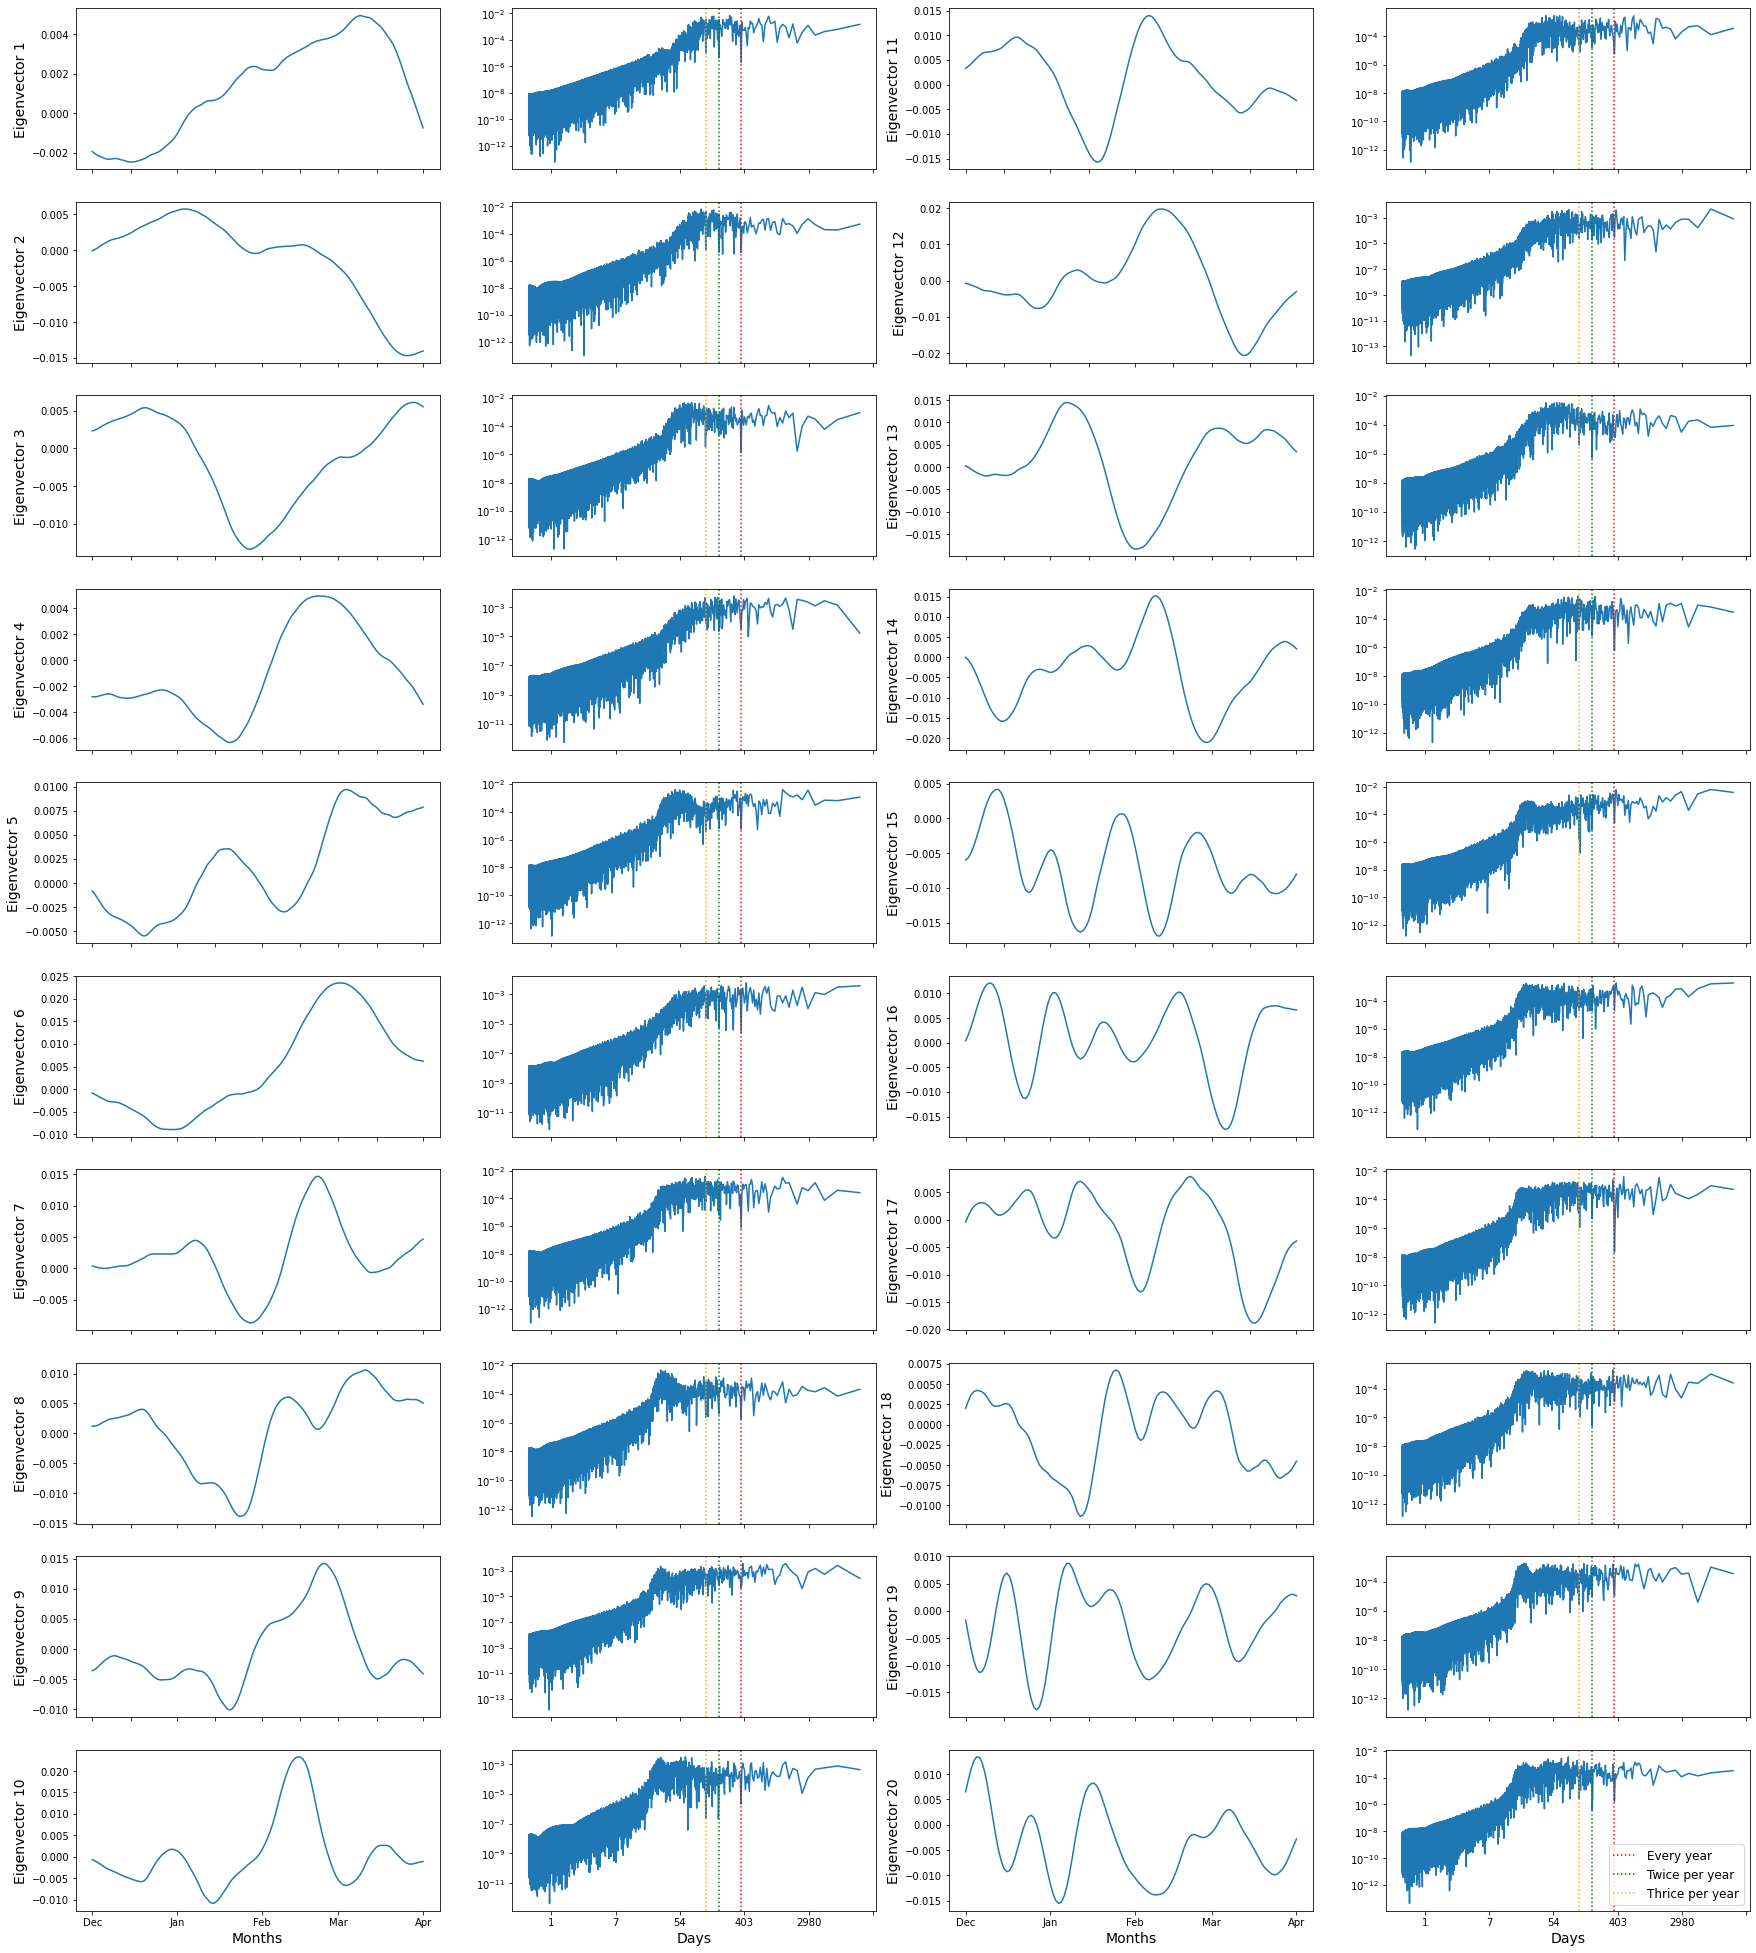

In [73]:
eigv_time_mean_nlsa = eigv_PCA.drop(['cluster_label_spectral_kernel'], axis=1)
if DATA == 'raw':
    sign_mean = [0, 1, 1, -1, -1,1,1,1,1,1,1,1, 1, -1, -1,1,1,1,1,1,1]
    sign_simple = [0, 1, 1, -1, -1,-1,1,-1,1,1,1,1, 1, -1, -1,1,1,1,1,1,1]
    if USE_TAKENS:
        sign_mean = [0, 1, 1, -1, -1,1,1,1,1,1,1,1, 1, -1, -1,1,1,1,1,1,1]
        sign_simple = [0, 1, 1, 1, -1,-1,-1,1,-1,1,-1,-1, 1, 1, 1,-1,-1,1,1,1,1]
else:
    sign_mean = [0, 1, 1, -1, -1,1,1,1,1,1,1,1, 1, -1, -1,1,1,1,1,1,1]
    sign_simple = [0, 1, 1, 1, -1,1,1,1,-1,1,1,1, 1, 1, 1,1,1,-1,1,-1,-1]
    if USE_TAKENS:
        sign_mean = [0, 1, 1, -1, -1,1,1,1,1,1,1,1, 1, -1, -1,1,1,1,1,1,1]
        sign_simple = [0, -1, 1, 1, -1,-1,1,1,1,1,-1,1, 1, -1, 1,-1,1,-1,-1,1,1]
    
fig, axs = plt.subplots(10, 4, figsize=(30, 35))
m = 1
n = 1
for j in range(4):
    for i in range(10):
        if j==0 or j==2:
            winter_2008 = pd.date_range('2008-12', '2009-04')
            winter_2008_eig_mean = eigv_time_mean_nlsa[n][winter_2008]

            axs[i, j].plot(winter_2008_eig_mean.index,
                           sign_mean[n] * winter_2008_eig_mean.values,
                           label='heat kernel')

            axs[i, j].set_xticklabels([])
            axs[i, j].set_ylabel(f"Eigenvector {n}")
            if i==9:
                #axs[i, j].set_xticklabels(['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Ap'])
                year = 2008
                axs[i, j].set_xticks((str(year) + '-12', str(year + 1) + '-01',
                                  str(year + 1) + '-02', str(year + 1) + '-03',
                                  str(year + 1) + '-04'))
                axs[i, j].set_xticklabels(['Dec', 'Jan', 'Feb', 'Mar', 'Apr'])
                axs[i,j].set_xlabel('Months')
            n += 1
        else:   
            pwr_compl(eigv_time_mean_nlsa, sampling_rate_days, m, axs[i,j])
            m+= 1
            if i==9:
                axs[i,j].set_xticklabels(['0', '1', '7', '54', '403', '2980'])
                axs[i,j].set_xlabel('Days')
plt.legend()

### Projection on geographical data: 
Perform projection $X'\in R^{1001x1}= X^T D \phi_i$. $X'_i = X D\phi_i \phi_i^T, \phi \in R^{33960}, X \in R^{Nx1001}$ 

In [ ]:
%%time
chosen_t = 'mean'
if DATA == 'anomalies':
    if USE_TAKENS:
        print(f'Reading {DATA} data from {INPUT_DATA}')
        df = pd.read_csv(INPUT_DATA + 'anomalies_coefficients.csv', sep=',')
        print(f'Reading eigenvectors from {PATH1}')
        eigv = pd.read_pickle(PATH1 + 't_' + chosen_t +
                              '/takens/eigenvectors_heat_matrix_t_' +
                              chosen_t + '_takens_.pkl').values
        eigv = pd.DataFrame(eigv).drop([0], axis=1).values

    else:
        print(f'Reading {DATA} data from {INPUT_DATA}')
        df = pd.read_csv(INPUT_DATA + 'anomalies_coefficients.csv', sep=',')
        print(f'Reading eigenvectors from {PATH1}')
        eigv = pd.read_pickle(
            PATH1 + 't_mean/eigenvectors_heat_matrix_t_mean_.pkl').values
        eigv = pd.DataFrame(eigv).drop([0], axis=1).values

else:
    if USE_TAKENS:
        print(f'Reading {DATA} data from {INPUT_DATA}')
        df = pd.read_csv(INPUT_DATA + 'raw_data_coefficients.csv', sep=',')
        print(f'Reading eigenvectors from {PATH1}')
        eigv = pd.read_pickle(PATH1 + 't_' + chosen_t +
                              '/takens/eigenvectors_heat_matrix_t_' +
                              chosen_t + '_takens_.pkl').values
        eigv = pd.DataFrame(eigv).drop([1], axis=1).values
    else:
        print(f'Reading {DATA} data from {INPUT_DATA}')
        df = pd.read_csv(INPUT_DATA + 'raw_data_coefficients.csv', sep=',')
        print(f'Reading eigenvectors from {PATH1}')
        eigv = pd.read_pickle(
            PATH1 + 't_mean/eigenvectors_heat_matrix_t_mean_.pkl').values
        eigv = pd.DataFrame(eigv).drop([1], axis=1).values

print(f'Reading diagonal matrix from {PATH1}')
if USE_TAKENS:
    D = pd.read_pickle(PATH1 +
                       't_mean/takens/diagonal_heat_matrix_t_mean_takens_.pkl').values
    X = df.drop(['Unnamed: 0', 'Date'], axis=1)
    X_nlsa = X.loc[indices_of_points[0]]
    for i in range(1, len(last_pos_winters)):
        X_nlsa = pd.concat([X_nlsa, X.loc[indices_of_points[i]]], axis = 0)
    Xt = X_nlsa.values.transpose()
else:
    D = pd.read_pickle(PATH1 +
                       't_mean/diagonal_heat_matrix_t_mean_.pkl').values

    Xt = df.drop(['Unnamed: 0', 'Date'], axis=1).values.transpose()

print(f'Xt shape: {Xt.shape}')
print(f'Diagonal matrix shape: {D.shape}')
print(f'Eigenvectors shape: {eigv.shape}')

Projections on eigenvectors:

In [ ]:
for i in range(NUM_EIGENVALUES-1):
    X_prime_i = Xt @ D @  eigv[:,i]
    np.save(PATH1 +'t_mean/takens/'+ 'X_prime_{}_takens_.npy'.format(i), X_prime_i)
    print('Saving X_prime_{}_takens_.npy at {}'.format(i, PATH1+'t_mean/takens/'))
del Xt, D, eigv

### Comments: 
- First request a lot of eigenvectors and check that only one eigenvector that has eigenvalue close to zero (~$10^{-15}$) and might need to increase number of neighbours otherwise (check if graph is connected): **DONE FOR 50 EIGENVALUES, ONLY ONE ZERO**
- Take the mean over all winters : **DONE**
- Change to heat kernel and compute for different kernel values, and more than 10 eigenvectors. Plot also the eigenvalues. **DONE**
- To choose t: look at distances and take mean or max of all distances among neighbours. Check if t is not the squared of distance. For large t we should have something close to what we have now. 
- Move to anomaly data
- Power spectrum with missing data ? Compute power spectrum for other eigenvectors. So up to 7 months alright and then a gap and the rest should start at 360 and multiply by $365/(7x30)$ **DONE**

- anomaly data estimated seasonality from raw data. estimate smooth mean and remove it to obtain the anomaly. 
- switch from default weight to gaussian kernel, optimise bandwidth computational demanding, try multiple experiments, assess the best bandwidth also define what best means
- apply also to anomaly data to see if consistent
- include to the model so that it can capture the dynamics of system, those things are called backends embedding (use multiple time steps to represent one sample -> sequences) —> apply and optimite previous all to new representation of data 

Pic raw data so that the first mode of variability should be the seasonality 
capturing something, huge variability but don’t know what

gaussian kernel approximates distance on manifold using this laplacian graph. The 0-1 weights is not very realistic because two samples that might be similar they might be different, For now they all have the sae weight. Not very good to approximate distances. For bandwidth t goes to 0 and a lot of data, converge to the distance on the manifold. 
